## Attempt to run Continous-Time markov process for BD and MH Poisson processes

BD (birth/death) rate computed based on the hazard

MH has a constant rate and defines absolute time 

We run C temperatires and W walkers

We work using Product space approach

In [1]:
import os
from time import time
import pickle
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax import numpy as jnp
from functools import partial
from fastgb import fastgb
from globalfit.gb.generator import GBGenerator, fastgb_buffersize, FastGBExt
from globalfit.gb.block import GBBlock
from globalfit.gb.likelihood import GBLogLik
from globalfit.gb.likelihood_jax import GBLogLikJax
from globalfit.noise.generator import NoiseGenerator
from globalfit.gb.tools import XYZ2AET
from lisaorbits import EqualArmlengthOrbits

# from eryn.ensemble import EnsembleSampler
# from eryn.state import State
# from eryn.prior import ProbDistContainer, uniform_dist
# from eryn.utils import TransformContainer
# from eryn.moves import GaussianMove, StretchMove, CombineMove, MHMove
# from eryn.utils.utility import groups_from_inds

import corner


from ptdamh import proposals as Proposals
from ptdamh import ensemble_runner2 as ensemble_mcmc2
from ptdamh import BD_MH_step_numpy as BD_MH
from ptdamh import utilities


import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

plt.style.use(['seaborn-v0_8-ticks','seaborn-v0_8-deep'])

# %pylab inline

mpl.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (12,7)

%load_ext autoreload
%autoreload 2

/opt/anaconda3/envs/torch_env3_11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
jax.config.update("jax_enable_x64", True)
GF_REPO = os.path.realpath("/Users/stas/Projects/LISA/GlobalFit/global-fit/")

Tobs = 10485760.0
dt = 5.0
bsize = 64

In [3]:
### Let me get the data

np.random.seed(15)  # fixing the noise 

_noise_file = os.path.join(GF_REPO, 'auxfiles', 'noise_pars.h5')
_gbfile = os.path.join(GF_REPO, 'auxfiles', 'gb_true.h5')

_gbcat = GBGenerator.load_catalog(_gbfile)

gb_fband = [6.216e-3, 6.219e-3]
duration = [0, 10485760.0]
_sel = (_gbcat['Frequency'] > gb_fband[0]) & (_gbcat['Frequency'] < gb_fband[1])
_list = np.where(_sel)[0]

cfg = {
    "dt":dt,
    "gb_fband": gb_fband, 
    "AET": True,
    "ignore_T_channel": True,
    "domain": 'Frequency',
    "duration": duration, 
    "inputs": [
        {"add": [{"name":"cat", "generator": GBGenerator, "list": _list}], "file": _gbfile}, 
        {"add": [{"name":"cat", "generator": NoiseGenerator}], "file": _noise_file},
    ],
    "noise_params": _noise_file
} 
block = GBBlock(config=cfg)
block.load_tdi()
block.load_noise()

print (_gbcat[_list])

[(2.14104362e-23, 0.00621747, 3.08540766e-16,  0.19122362, 4.78383106, 1.44883313, 3.24941449, 3.90238858, 0., 0., 0., 0., 0., 0., 0., 0.,  7.47269928, 0., '', 0, 0.)
 (3.50476905e-23, 0.00621856, 1.31240183e-15, -0.16938328, 4.60813132, 1.79614242, 3.5511628 , 5.81270134, 0., 0., 0., 0., 0., 0., 0., 0., 13.37559459, 0., '', 0, 0.)
 (2.45939760e-23, 0.0062182 , 5.56699233e-16, -1.08865091, 3.03280483, 1.62098072, 1.30826979, 3.55278411, 0., 0., 0., 0., 0., 0., 0., 0.,  8.28745113, 0., '', 0, 0.)]


In [4]:
def _gbll_inst(cls, nsrcs, bsize, unroll_srcs=None, unroll_tdi=None):
    return cls(
        block.tdi,
        block.noise,
        block.fmin,
        block.fmax,
        smax=nsrcs,
        fgb_ext=bsize,
        unroll_srcs=unroll_srcs,
        unroll_tdi=unroll_tdi
    )

Nsrc=3
Npar_src = 8
dim = Nsrc * Npar_src
bsize = 64

fold_idx = (4, 6, 7, 4+Npar_src, 6+Npar_src, 7+Npar_src, 4+2*Npar_src, 6+2*Npar_src, 7+2*Npar_src, 4+3*Npar_src, 6+3*Npar_src, 7+3*Npar_src)

# _gbll_all = _gbll_inst(GBLogLikJax, Nsrc, bsize)

# _gbll = _gbll_inst(GBLogLik, Nsrc, bsize).loglik
jllkwargs = {}
# _jgbll = jax.vmap(jax.jit(_gbll_inst(GBLogLikJax, Nsrc, bsize, **jllkwargs).loglik))

GB2_loglik = jax.jit(_gbll_inst(GBLogLikJax, 2, bsize, **jllkwargs).loglik)
GB3_loglik = jax.jit(_gbll_inst(GBLogLikJax, 3, bsize, **jllkwargs).loglik)
GB4_loglik = jax.jit(_gbll_inst(GBLogLikJax, 4, bsize, **jllkwargs).loglik)



_srcHC245 = _gbll_inst(GBLogLik, 3, bsize).ldc_to_pars(_gbcat[_list], dicts=True)
print (_srcHC245)
_srcHC24 = _srcHC245[:2*Npar_src] 

_srcHC245p = np.concatenate((_srcHC24, np.random.random(Npar_src)), axis=0)

# print (_gbll(_srcHC245))

print ("make sure we fixed the noise", GB3_loglik(_srcHC245))
print ("try 4 sources", GB4_loglik(_srcHC245p))


[0.33265638 0.4898206  0.5084293  0.59503018 0.76137036 0.56083053
 0.65540519 0.08676368 0.38616485 0.85278449 0.53585466 0.41571276
 0.73340688 0.38827814 0.05549038 0.29474992 0.34770719 0.7330147
 0.51520896 0.05699891 0.48268588 0.47491833 0.98187836 0.64900794]
make sure we fixed the noise -203.45983125330835
try 4 sources -19776.971815328685


In [5]:
import jax
import jax.numpy as jnp
from jax import lax

def make_log_lik_masked_jax(GB2_loglik, GB3_loglik, GB4_loglik, Kmax: int = 4):
    """
    Returns a function:
       log_lik_masked_jax(phi_kwd: (Kmax,d), m_k: (Kmax,), rest_d: Optional[(Drest,)] ) -> scalar
    that:
      - picks k = sum(m_k) and calls GB{k}_loglik on the concatenated active φ_j (in slot order)
      - returns -inf if k ∉ {2,3,4} or any *active* parameter is outside [0,1]
    """

    def _build_theta_k(phi_kwd: jnp.ndarray, m_k: jnp.ndarray, k: int) -> jnp.ndarray:
        """Gather the first k active slots in slot order, flatten to length k*d."""
        d = phi_kwd.shape[1]
        idx = jnp.arange(Kmax)
        # push inactive indices to the end, then take first k
        order_key = jnp.where(m_k, idx, Kmax + idx)
        take = jnp.argsort(order_key)[:k]         # (k,)
        theta_k = phi_kwd[take, :].reshape((k * d,))  # (k*d,)
        return theta_k

    def _bounds_ok(phi_kwd: jnp.ndarray, m_k: jnp.ndarray) -> jnp.bool_:
        """Check Uniform[0,1] bounds on ACTIVE params only."""
        active = m_k[:, None]
        ge0 = (phi_kwd >= 0.0) | (~active)
        le1 = (phi_kwd <= 1.0) | (~active)
        return jnp.all(ge0 & le1)

    # Branches for k in {2,3,4}
    def _ll_k2(phi_kwd, m_k, rest_d):
        theta = _build_theta_k(phi_kwd, m_k, 2)
        return GB2_loglik(theta)

    def _ll_k3(phi_kwd, m_k, rest_d):
        theta = _build_theta_k(phi_kwd, m_k, 3)
        return GB3_loglik(theta)

    def _ll_k4(phi_kwd, m_k, rest_d):
        theta = _build_theta_k(phi_kwd, m_k, 4)
        return GB4_loglik(theta)

    branches = (_ll_k2, _ll_k3, _ll_k4)

    @jax.jit
    def log_lik_masked_jax(phi_kwd: jnp.ndarray,
                           m_k: jnp.ndarray,
                           rest_d: jnp.ndarray | None = None) -> jnp.ndarray:
        """
        phi_kwd: (Kmax, d)
        m_k:     (Kmax,)  boolean
        rest_d:  unused here (kept for API compatibility)
        """
        # k = number of active components
        k = jnp.int32(jnp.sum(m_k))

        # Bounds check on ACTIVE params; -inf if violated
        ok = _bounds_ok(phi_kwd, m_k)
        def _bad():  return jnp.array(-jnp.inf, dtype=jnp.float64)

        def _good():
            # Select branch 0,1,2 for k=2,3,4; otherwise -inf
            sel = k - 2
            in_range = (sel >= 0) & (sel <= 2)
            def _run():
                return lax.switch(sel, branches, phi_kwd, m_k, rest_d)
            return lax.cond(in_range, _run, _bad)

        return lax.cond(ok, _good, _bad)

    return log_lik_masked_jax

log_lik_masked_jax = make_log_lik_masked_jax(GB2_loglik, GB3_loglik, GB4_loglik, Kmax=4)

In [6]:
D = Npar_src        # parameter dimension per source
Kmax = 4     # max number of slots

# Example: define phi for 4 slots (random uniform [0,1])
phi_example = jnp.array(np.random.rand(Kmax, D))

# Case 1: k=2 active slots
m2 = jnp.array([1, 1, 0, 0], dtype=bool)
ll2 = log_lik_masked_jax(phi_example, m2, None)
print(m2, "k=2 masked loglik:", ll2)

# Case 2: k=3 active slots
m3 = jnp.array([1, 1, 1, 0], dtype=bool)
ll3 = log_lik_masked_jax(phi_example, m3, None)
print(m3, "k=3 masked loglik:", ll3)

# Case 3: k=4 active slots
m4 = jnp.array([1, 1, 1, 1], dtype=bool)
ll4 = log_lik_masked_jax(phi_example, m4, None)
print(m4, "k=4 masked loglik:", ll4)

# Case 4: invalid k=1 -> should give -inf
m1 = jnp.array([1, 0, 0, 0], dtype=bool)
ll1 = log_lik_masked_jax(phi_example, m1, None)
print(m1, "k=1 masked loglik (should be -inf):", ll1)

# Case 5: active parameter out of bounds -> -inf
phi_bad = phi_example.at[0, 0].set(1.5)   # set one param > 1.0
ll_bad = log_lik_masked_jax(phi_bad, m2, None)
print("out-of-bounds param (should be -inf):", ll_bad)

[ True  True False False] k=2 masked loglik: -28200353.869480677
[ True  True  True False] k=3 masked loglik: -28217017.71879462
[ True  True  True  True] k=4 masked loglik: -27856678.26279795
[ True False False False] k=1 masked loglik (should be -inf): -inf
out-of-bounds param (should be -inf): -inf


In [ ]:
Num_temps = 10
Tmax = 5
Kmax = 4     # max number of slots/sources
Nsrc = 3
Npar_src = 8
dim = Kmax * Npar_src
walkers = 16

C = Num_temps
D = dim
W = walkers

rng_np = np.random.default_rng(42)

base_cov = np.diag(np.full(dim, 0.01**2))
base_cov_k3 = np.load('cov_k3.npy')
base_cov[:3*Npar_src, :3*Npar_src] = base_cov_k3[:3*Npar_src, :3*Npar_src]
cov = np.broadcast_to(base_cov, (Num_temps, dim, dim))

temps = utilities.temperature_ladder(n_temps=Num_temps, T_min=1.0, T_max=Tmax, kind="geom", cold_dense=False, power=1.5)
print ('temperatures', temps)
betas = 1./temps


I = jnp.eye(D)[None, :, :]
jitter = 1e-9
sym = 0.5 * (cov + jnp.swapaxes(cov, -1, -2)) + jitter * I

L_chol = jnp.linalg.cholesky(sym)  # (C, D, D)

S, U = jnp.linalg.eigh(sym)
S = jnp.clip(S, 1e-12, None)

print ('matrices', L_chol.shape, S.shape, U.shape)

initial_phis = np.random.random((W, dim))
print (initial_phis.shape)
for ii in range(W):
    initial_phis[ii, :Nsrc*Npar_src] = _srcHC245

def log_prior_phi(theta):
    return 0.0  ### uniform prior over the unit hypercube

def log_pseudo_phi(theta):
    return 0.0  ### uniform pseudo-prior over the unit hypercube

# Uniform prior over k ∈ {2,3,4}; -inf otherwise : models prior
def log_p_k(k_arr: np.ndarray) -> np.ndarray:
    out = np.full_like(k_arr, -np.inf, dtype=np.float64)
    mask = (k_arr == 2) | (k_arr == 3) | (k_arr == 4)
    out = np.where(mask, -np.log(3.0), out)
    return out

print (log_p_k(np.array([1, 2, 3, 4, 5])))

# ---- Birth/Death “rate density” qb ------
def qb_density_np(phi_j_cw: np.ndarray,
                  m_ctx_cw: np.ndarray,
                  phi_all_cw: np.ndarray,
                  rest_cw: np.ndarray | None) -> np.ndarray:
    # shape: (C,W,d), (C,W,Kmax), (C,W,Kmax,d) -> return (C,W)
    return np.ones(phi_j_cw.shape[:2], dtype=np.float64)


def sample_pseudo_phi() -> np.ndarray:
    return rng_np.uniform(0.0, 1.0, size=(Npar_src,)).astype(np.float64)

# Start with k=2 active everywhere (slots 0 and 1 ON)
m0 = np.zeros((C, W, Kmax), dtype=bool)
m0[:, :, :2] = True
# m0[:, :, :3] = True


# print (m0)
# Initial state: (C, W, Kmax, Npar_src)
# This is the 'phi' state for the W walkers
phi_for_walkers = initial_phis.reshape(W, Kmax, Npar_src)
print(f"Reshaped phi for W walkers: {phi_for_walkers.shape}")
theta0 = np.broadcast_to(phi_for_walkers, (C, W, Kmax, Npar_src))
print(f"Final initial phi state shape (C, W, Kmax, Npar_src): {theta0.shape}")


# Slot mapping: pack φ_j (d dims) into θ (D dims)
slot_slices = tuple(slice(j*Npar_src, (j+1)*Npar_src) for j in range(Kmax))
print ('slot_slice', slot_slices)

# θ packs φ_j into contiguous slices
th0 = np.zeros((C, W, D), dtype=np.float64)
for j in range(Kmax):
    sl = slot_slices[j]
    th0[:, :, sl] = theta0[:, :, j, :]

print (th0.shape)

batched_ll_masked = BD_MH.make_batched_loglik_masked(log_lik_masked_jax)
rest = None

B = C * W
ll0 = batched_ll_masked(
    theta0.reshape(B, Kmax, Npar_src),
    m0.reshape(B, Kmax), 
    rest
).reshape(C, W)

print (ll0[0, :])


pt_init = BD_MH.PTState(thetas=th0, log_probs=ll0)   # log_probs = masked LL
ps_init = BD_MH.PSState(phi=theta0, m=m0, rest=rest, logpi=np.zeros((C, W), dtype=np.float64))

temperatures [ 1.         1.2915497  1.6681006  2.1544347  2.7825596  3.593814
  4.641589   5.994843   7.7426376 10.000001 ]
matrices (10, 32, 32) (10, 32) (10, 32, 32)
(16, 32)
[       -inf -1.09861229 -1.09861229 -1.09861229        -inf]
Reshaped phi for W walkers: (16, 4, 8)
Final initial phi state shape (C, W, Kmax, Npar_src): (10, 16, 4, 8)
slot_slice (slice(0, 8, None), slice(8, 16, None), slice(16, 24, None), slice(24, 32, None))
(10, 16, 32)
[-243.38607199 -243.38607199 -243.38607199 -243.38607199 -243.38607199
 -243.38607199 -243.38607199 -243.38607199 -243.38607199 -243.38607199
 -243.38607199 -243.38607199 -243.38607199 -243.38607199 -243.38607199
 -243.38607199]


In [8]:
# ---- Runner knobs ------------------------------------------------------------
T_end = 600.0            # total CTMC time
rho_mh = 10.0          # MH global Poisson rate
do_stretch = True
do_rw_fullcov = True  # keep off to avoid needing Ls
do_de = True
do_PTswap = True
bd_rate_scale = 1.0

trace_conf = BD_MH.TraceConfig(chain_inds=[0,3,5])#, keep_bd_snapshots=True, keep_ps_snapshots=True)

In [9]:
pt_out, ps_out, events, results = BD_MH.run_epoch_ct_numpy(
    seed=123,
    pt_init=pt_init,
    ps_init=ps_init,
    T_end=T_end,
    rho_mh=rho_mh,
    betas=betas,
    qb_density_np=qb_density_np,
    qb_eval_variant="child",                 # evaluate qb in child context for births; parent for deaths (handled inside)
    log_prior_phi_np=log_prior_phi,
    log_pseudo_phi_np=log_pseudo_phi,
    log_p_k_np=log_p_k,
    log_lik_masked_jax=log_lik_masked_jax,  # JAX single-config (masked)
    slot_slices=slot_slices,
    # RW resources
    Ls=L_chol, U=U, S=S,
    # MH knobs
    do_stretch=do_stretch,
    do_rw_fullcov=do_rw_fullcov,
    do_rw_eigenline=False,
    do_rw_student_t=False,
    do_PTswap=do_PTswap,
    do_de=do_de,
    stretch_a=1.3,
    cross_rate=0.7,
    gamma_de=2.38,
    # pseudo-prior sampler
    sample_pseudo_phi=sample_pseudo_phi,
    trace_cfg=trace_conf,
    bd_rate_scale=bd_rate_scale,
)


CT-MCMC run: 100%|██████████| 600.0/600.0 [40:15<00:00,  4.03s/time]                   


In [10]:
from ptdamh.BD_MH_step_numpy import RunTrace
from ptdamh.BD_MH_step_numpy import MHTick, BDEventWithState

from typing import Tuple, Optional, Literal, List

from collections import defaultdict
from typing import Dict, List, Tuple, Optional


# If not globally available:
MOVE_IDS = {"stretch": 0, "rw_fullcov": 1, "rw_eigenline": 2,
            "rw_student_t": 3, "de": 4, "ptswap": 5}
INV_MOVE_IDS = {v:k for k,v in MOVE_IDS.items()}

def total_time_from_trace(trace: RunTrace) -> float:
    t_bd = trace.bd_events[-1].t_abs if trace.bd_events else 0.0
    t_mh = trace.mh_ticks[-1].t_abs if trace.mh_ticks else 0.0
    return max(t_bd, t_mh)

def _last_tick_state_snapshot(tick: MHTick):
    """Use the *final* state of the MH tick (after last submove)."""
    if not tick.submoves:
        return None  # corner case: empty tick
    snap = tick.submoves[-1]
    return snap.phi_sel, snap.m_sel  # shapes: (Csel,W,Kmax,d), (Csel,W,Kmax)

def _selected_state_after_bd(ev: BDEventWithState):
    """State *after* the BD event (already stored)."""
    return ev.phi_sel, ev.m_sel


In [11]:
def collect_phi_samples_by_k(
    trace: RunTrace,
    temp_index: int = 0,            # index inside trace.chain_inds
    *,
    include_bd: bool = True,
    include_mh: bool = True,
    thin_bd: int = 1,
    thin_mh: int = 1,
) -> Dict[int, np.ndarray]:
    """
    Return dict: k -> array (N_k, k, d) of *all* active φ's (ordered as stored) for that temperature.
    No time-weighting here (pure snapshots).
    """
    W, Kmax, d = trace.W, trace.Kmax, trace.d
    out: Dict[int, List[np.ndarray]] = defaultdict(list)

    if include_bd:
        for ev in trace.bd_events[::thin_bd]:
            phi = ev.phi_sel[temp_index]  # (W,Kmax,d)
            m   = ev.m_sel[temp_index]    # (W,Kmax)
            for w in range(W):
                act = m[w]                # (Kmax,)
                k = int(act.sum())
                if k > 0:
                    out[k].append(phi[w, act, :])  # (k,d)

    if include_mh:
        for tick in trace.mh_ticks[::thin_mh]:
            for snap in tick.submoves:
                phi = snap.phi_sel[temp_index]     # (W,Kmax,d)
                m   = snap.m_sel[temp_index]       # (W,Kmax)
                for w in range(W):
                    act = m[w]
                    k = int(act.sum())
                    if k > 0:
                        out[k].append(phi[w, act, :])

    return {k: np.stack(v, axis=0) for k, v in out.items() if len(v) > 0}

temp_idx = 0
res_k = collect_phi_samples_by_k(results, temp_index=temp_idx)

In [12]:
print (res_k.keys())
print (res_k[2].shape)
print (res_k[3].shape)
print (res_k[4].shape)

print ('k=2', res_k[2][0, :, :]) ## two sources
print ('k=3', res_k[3][0, :, :]) ## three sources
print ('k=4', res_k[4][0, :, :]) ## four sources

dict_keys([2, 3, 4])
(123660, 2, 8)
(924504, 3, 8)
(261772, 4, 8)
k=2 [[0.33265638 0.4898206  0.5084293  0.59503018 0.76137036 0.56083053
  0.65540519 0.08676368]
 [0.38616485 0.85278449 0.53585466 0.41571276 0.73340688 0.38827814
  0.05549038 0.29474992]]
k=3 [[0.33265638 0.4898206  0.5084293  0.59503018 0.76137036 0.56083053
  0.65540519 0.08676368]
 [0.38490075 0.8587742  0.65968425 0.42837174 0.74602236 0.37248566
  0.34644024 0.57258756]
 [0.05429109 0.86617043 0.02265399 0.53047512 0.89491788 0.57248958
  0.60841675 0.68161085]]
k=4 [[0.34812749 0.48342179 0.60350066 0.53431629 0.75680587 0.50348212
  0.54511916 0.00763564]
 [0.39847803 0.85521261 0.72953097 0.40601588 0.74756432 0.38417712
  0.36718094 0.62434245]
 [0.21085148 0.7331988  0.3328682  0.89618582 0.30228184 0.51860244
  0.98038251 0.99752736]
 [0.02090561 0.83723486 0.35262746 0.59576723 0.9505399  0.44304217
  0.55285325 0.02324875]]


In [43]:
def time_weighted_phi_by_k(
    trace: RunTrace,
    temp_index: int = 0,
    *,
    thin_bd: int = 1,
    thin_mh: int = 1,
    include_initial: bool = False,     # set True if you want the pre-first-event initial state
) -> Dict[int, Tuple[np.ndarray, np.ndarray]]:
    """
    Returns dict: k -> (samples, weights)
      samples: (N_k, k, d)
      weights: (N_k,)   (CT time weights)
    """
    Csel, W, Kmax, d = len(trace.chain_inds), trace.W, trace.Kmax, trace.d

    # Build unified timeline: (t_abs, kind, index)
    # kind: 0=BD, 1=MH
    bd_list = [(ev.t_abs, 0, i) for i, ev in enumerate(trace.bd_events)][::thin_bd]
    mh_list = [(tick.t_abs, 1, i) for i, tick in enumerate(trace.mh_ticks)][::thin_mh]
    all_ev = bd_list + mh_list
    if not all_ev:
        return {}

    all_ev.sort(key=lambda x: x[0])
    T = total_time_from_trace(trace)

    # Helper to fetch state snapshot (phi_sel, m_sel) AFTER the event
    def get_state(kind, idx):
        if kind == 0:  # BD
            ev = trace.bd_events[idx]
            return ev.phi_sel, ev.m_sel
        else:          # MH
            tick = trace.mh_ticks[idx]
            res = _last_tick_state_snapshot(tick)
            if res is None:
                return None, None
            return res

    # Optional: initial state (before first event) gets weight = dt(first_event)
    out_samples: Dict[int, List[np.ndarray]] = defaultdict(list)
    out_weights: Dict[int, List[float]] = defaultdict(list)

    if include_initial:
        first_t, _, first_i = all_ev[0]
        # We don't have an initial snapshot in RunTrace; skip unless you saved it yourself.

    # For each event i, the state that persists *after* this event holds until next event
    for i, (t_abs, kind, idx) in enumerate(all_ev):
        phi_sel, m_sel = get_state(kind, idx)  # shapes: (Csel,W,Kmax,d), (Csel,W,Kmax)
        if phi_sel is None:
            continue
        # weight = time until the next event (or T - t_abs for the last)
        if i + 1 < len(all_ev):
            next_dt = all_ev[i+1][0] - t_abs
        else:
            next_dt = max(0.0, T - t_abs)
        if next_dt <= 0.0:
            continue

        phi = phi_sel[temp_index]  # (W,Kmax,d)
        m   = m_sel[temp_index]    # (W,Kmax)

        for w in range(W):
            act = m[w]
            k = int(act.sum())
            if k > 0:
                out_samples[k].append(phi[w, act, :])  # (k,d)
                out_weights[k].append(next_dt)

    # Stack
    return {
        k: (np.stack(out_samples[k], axis=0), np.asarray(out_weights[k], dtype=float))
        for k in out_samples.keys()
    }

def posterior_over_k(
    trace: RunTrace,
    temp_index: int = 0,
    *,
    weighted: bool = True,
    thin_bd: int = 1,
    thin_mh: int = 1,
) -> np.ndarray:
    """
    Empirical p(k|y) for the chosen temperature.
    If weighted=True, use CT time weights (recommended).
    """
    Kmax = trace.Kmax
    counts = np.zeros(Kmax + 1, dtype=float)

    # Build timeline as above
    bd_list = [(ev.t_abs, 0, i) for i, ev in enumerate(trace.bd_events)][::thin_bd]
    mh_list = [(tick.t_abs, 1, i) for i, tick in enumerate(trace.mh_ticks)][::thin_mh]
    all_ev = bd_list + mh_list
    if not all_ev:
        return counts
    all_ev.sort(key=lambda x: x[0])
    T = total_time_from_trace(trace)

    def k_of_state(kind, idx):
        if kind == 0:
            ev = trace.bd_events[idx]
            m = ev.m_sel[temp_index]  # (W,Kmax)
        else:
            tick = trace.mh_ticks[idx]
            snap = _last_tick_state_snapshot(tick)
            if snap is None:
                return None
            _, m_sel = snap
            m = m_sel[temp_index]
        return m.sum(axis=1).astype(int)  # (W,)

    for i, (t_abs, kind, idx) in enumerate(all_ev):
        ks = k_of_state(kind, idx)
        if ks is None:
            continue
        if weighted:
            if i + 1 < len(all_ev):
                w = all_ev[i+1][0] - t_abs
            else:
                w = max(0.0, T - t_abs)
        else:
            w = 1.0
        # add W walkers’ contribution (each walker's k contributes equally)
        binc = np.bincount(ks, minlength=Kmax+1).astype(float)
        counts += w * binc

    if counts.sum() > 0:
        counts /= counts.sum()
    return counts

def posterior_samples_for_k_with_scores(
    trace,                      # RunTrace
    k: int,
    temp_index: int = 0,        # index within trace.chain_inds (0..Csel-1)
    include_mh: bool = True,
    mh_skip_first: int = 5,  
    include_bd: bool = False,
    thin: int = 1,
    weight_by: Literal["uniform", "dt", "none"] = "uniform",
    mh_snapshot_policy: Literal["last", "all", "accepted_only"] = "last",
    # Optional callbacks to reconstruct ll for BD snapshots
    log_prior_phi_np: Optional[callable] = None,
    log_pseudo_phi_np: Optional[callable] = None,
    log_p_k_np: Optional[callable] = None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Extract posterior samples for model size k at selected temperature, with weights and scores.

    Returns:
      Xk   : (N, k, d)   active φs per sample (order = slot index)
      wk   : (N,)        weights (normalized if weight_by != 'none')
      ll   : (N,)        masked log-likelihood; BD entries are NaN unless callbacks provided
      logpi: (N,)        tempered log posterior (PS)
    """
    # sanity
    assert 0 <= temp_index < trace.chain_inds.size, "temp_index out of range"
    csel = int(temp_index)
    d = int(trace.d)
    Kmax = int(trace.Kmax)

    X_list: List[np.ndarray] = []
    w_list: List[float] = []
    ll_list: List[float] = []
    logpi_list: List[float] = []

    def _append_batch(phi_sel, m_sel, ll_sel, logpi_sel, base_wt, share_over: int = 1):
        """Append all walkers that have exactly k active sources.
        share_over splits 'base_wt' across multiple snapshots from the same MH tick."""
        phi_c = phi_sel[csel]      # (W, Kmax, d)
        m_c   = m_sel[csel]        # (W, Kmax)
        lp_c  = logpi_sel[csel]    # (W,)
        ll_c  = None if ll_sel is None else ll_sel[csel]  # (W,) or None
        W = phi_c.shape[0]
        if share_over < 1: share_over = 1
        wt = float(base_wt) / float(share_over)

        for w in range(W):
            act = m_c[w].astype(bool)             # (Kmax,)
            kk  = int(act.sum())
            if kk != k:
                continue
            Xkw = phi_c[w, act, :]               # (k, d)
            X_list.append(Xkw)
            w_list.append(wt)
            ll_list.append(float(ll_c[w]) if ll_c is not None else np.nan)
            logpi_list.append(float(lp_c[w]))

    # ---------------- MH snapshots ----------------
    if include_mh:
        for i_tick, tick in enumerate(trace.mh_ticks):
            if thin > 1 and (i_tick % thin != 0):
                continue

            snaps = tick.submoves or []
            if not snaps:
                continue

            if mh_snapshot_policy == "last":
                # 'last' ignores mh_skip_first by design; if you prefer otherwise:
                # if mh_skip_first >= len(snaps): continue
                snaps_iter = snaps[-1:]
            elif mh_snapshot_policy == "accepted_only":
                snaps_iter = [s for s in snaps if np.any(s.accepted)]
                # apply skipping *after* policy
                if mh_skip_first > 0:
                    snaps_iter = snaps_iter[mh_skip_first:]
            else:  # "all"
                snaps_iter = snaps
                if mh_skip_first > 0:
                    snaps_iter = snaps_iter[mh_skip_first:]

            if not snaps_iter:
                continue

            # weight per tick
            base_wt = 1.0 if weight_by in ("uniform", "none") else float(tick.dt)
            # share dt across the snapshots we actually keep
            share = max(1, len(snaps_iter)) if weight_by == "dt" else 1

            for snap in snaps_iter:
                _append_batch(
                    snap.phi_sel, snap.m_sel, snap.ll_sel, snap.logpi_sel,
                    base_wt=base_wt, share_over=share
                )

    # ---------------- BD snapshots ----------------
    if include_bd and trace.bd_events:
        # If we can reconstruct ll from logpi, do it; else keep NaN.
        have_ll_callbacks = (log_prior_phi_np is not None and
                             log_pseudo_phi_np is not None and
                             log_p_k_np is not None)
        beta = float(trace.betas[trace.chain_inds[csel]])
        for i_ev, bev in enumerate(trace.bd_events):
            if thin > 1 and (i_ev % thin != 0):
                continue
            base_wt = 1.0 if weight_by in ("uniform", "none") else float(bev.dt)

            if not have_ll_callbacks:
                _append_batch(bev.phi_sel, bev.m_sel, None, bev.logpi_sel, base_wt, share_over=1)
            else:
                # reconstruct ll from logpi = comb + comp + β*ll  => ll = (logpi - comb - comp)/β
                phi_sel, m_sel, logpi_sel = bev.phi_sel, bev.m_sel, bev.logpi_sel
                # build comp/comb for the selected chains
                phi_c = phi_sel[csel]      # (W,Kmax,d)
                m_c   = m_sel[csel]        # (W,Kmax)
                W = phi_c.shape[0]
                comp = np.zeros((W,), dtype=float)
                for i in range(Kmax):
                    # vectorize over walkers
                    act_i = m_c[:, i]
                    # prior if active else pseudo
                    for w in range(W):
                        comp[w] += (log_prior_phi_np(phi_c[w, i])
                                    if act_i[w] else log_pseudo_phi_np(phi_c[w, i]))
                k_w = m_c.astype(int).sum(axis=1)   # (W,)
                comb = log_p_k_np(k_w) \
                     + (- (np.math.lgamma(Kmax+1) - np.vectorize(np.math.lgamma)(k_w+1) - np.vectorize(np.math.lgamma)(Kmax-k_w+1))) \
                     + ( - np.vectorize(np.math.lgamma)(k_w+1) )
                # ll per walker:
                ll_recon = (logpi_sel[csel] - comb - comp) / max(beta, 1e-12)
                # pack into a fake ll_sel with (Csel,W)
                ll_fake = np.zeros_like(logpi_sel)
                ll_fake[csel] = ll_recon
                _append_batch(phi_sel, m_sel, ll_fake, logpi_sel, base_wt, share_over=1)

    # ---------------- finalize ----------------
    if len(X_list) == 0:
        return (np.zeros((0, k, d), dtype=float),
                np.zeros((0,), dtype=float),
                np.zeros((0,), dtype=float),
                np.zeros((0,), dtype=float))

    Xk   = np.stack(X_list, axis=0)        # (N,k,d)
    wk   = np.asarray(w_list, dtype=float) # (N,)
    ll   = np.asarray(ll_list, dtype=float)# (N,)
    logp = np.asarray(logpi_list, dtype=float)

    if weight_by != "none":
        s = wk.sum()
        wk = wk / s if s > 0 else np.full_like(wk, 1.0 / max(1, wk.size))

    return Xk, wk, ll, logp


def bayes_factors_from_postk(post_k: np.ndarray, prior_k: Optional[np.ndarray] = None,
                             ks: Optional[List[int]] = None) -> Dict[Tuple[int,int], float]:
    Kmax = len(post_k) - 1
    if ks is None:
        ks = [k for k in range(Kmax + 1) if post_k[k] > 0]
    if prior_k is None:
        prior_k = np.ones_like(post_k, float); prior_k /= prior_k.sum()
    else:
        prior_k = np.asarray(prior_k, float); prior_k /= prior_k.sum()

    BF = {}
    for i in range(len(ks)):
        for j in range(i+1, len(ks)):
            k1, k2 = ks[i], ks[j]
            if post_k[k1] > 0 and post_k[k2] > 0 and prior_k[k1] > 0 and prior_k[k2] > 0:
                BF[(k1,k2)] = (post_k[k1]/post_k[k2]) / (prior_k[k1]/prior_k[k2])
            else:
                BF[(k1,k2)] = np.nan
    return BF

def posterior_samples_for_k(
    trace: RunTrace,
    k: int,
    temp_index: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns:
      X:  (N, k, d)  time-weighted posterior samples for model k
      w:  (N,)       corresponding CT weights
    """
    by_k = time_weighted_phi_by_k(trace, temp_index=temp_index)
    if k not in by_k:
        return np.empty((0, k, trace.d)), np.empty((0,))
    return by_k[k]

def flatten_for_corner(X_k: np.ndarray) -> np.ndarray:
    """(N,k,d) -> (N, k*d)"""
    N, k, d = X_k.shape
    return X_k.reshape(N, k*d)

M4:Xk shape: (18781, 4, 8)
weights shape: (18781,)
ll (masked) shape: (18781,)
logpi shape: (18781,)
M3: Xk shape: (66408, 3, 8)
weights shape: (66408,)
ll (masked) shape: (66408,)
logpi shape: (66408,)
M2: Xk shape: (8843, 2, 8)
weights shape: (8843,)
ll (masked) shape: (8843,)
logpi shape: (8843,)


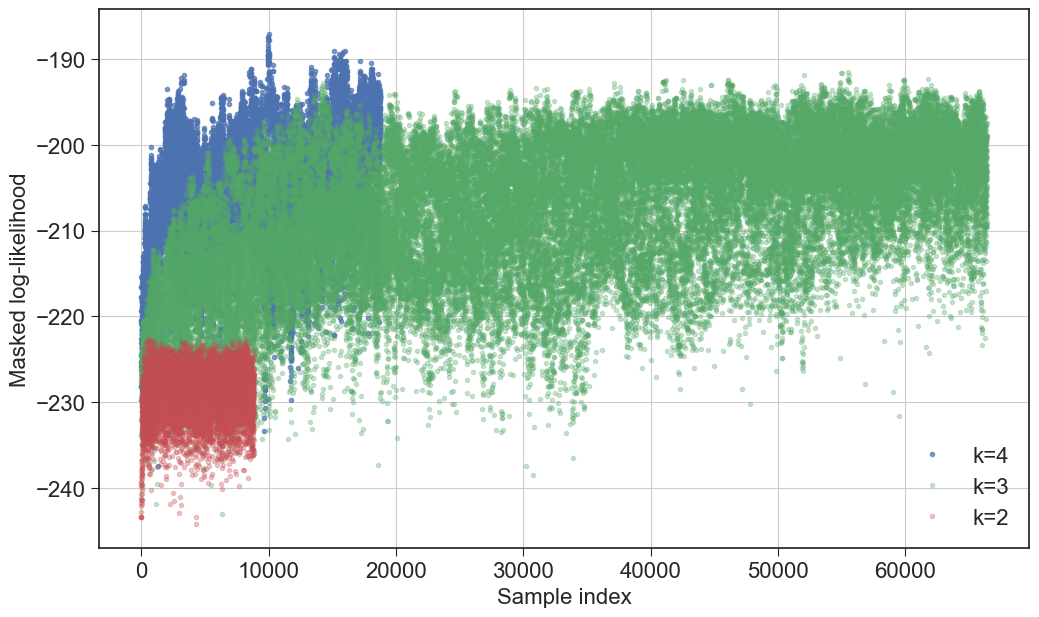

[-229.76785264 -224.49335251 -226.25861033 ... -194.36857986 -197.71863564
 -195.14829564]


In [14]:
# (1) Time-weighted posterior samples per k
Xk4, wk4, ll4, logpi4 = posterior_samples_for_k_with_scores(results, k=4, temp_index=temp_idx,
                                                           include_mh=True, include_bd=False,
                                                           weight_by="dt", 
                                                         #   mh_snapshot_policy="accepted_only",
                                                           mh_snapshot_policy="last",
                                                         #   mh_snapshot_policy="all",
                                                           mh_skip_first=10)
print("M4:Xk shape:", Xk4.shape)            # (N, 4, d)
print("weights shape:", wk4.shape)       # (N,)
print("ll (masked) shape:", ll4.shape)   # (N,)
print("logpi shape:", logpi4.shape)      # (N,)

Xk3, wk3, ll3, logpi3 = posterior_samples_for_k_with_scores(results, k=3, temp_index=temp_idx,
                                                           include_mh=True, include_bd=False,
                                                           weight_by="dt", 
                                                        #    mh_snapshot_policy="accepted_only",
                                                           mh_snapshot_policy="last",
                                                         #   mh_snapshot_policy="all",
                                                           mh_skip_first=10)
print("M3: Xk shape:", Xk3.shape)            # (N, 3, d)
print("weights shape:", wk3.shape)       # (N,)
print("ll (masked) shape:", ll3.shape)   # (N,)
print("logpi shape:", logpi3.shape)      # (N,)

Xk2, wk2, ll2, logpi2 = posterior_samples_for_k_with_scores(results, k=2, temp_index=temp_idx,
                                                           include_mh=True, include_bd=False,
                                                           weight_by="dt", 
                                                        #    mh_snapshot_policy="accepted_only",
                                                           mh_snapshot_policy="last",
                                                         #   mh_snapshot_policy="all",
                                                           mh_skip_first=1)
print("M2: Xk shape:", Xk2.shape)            # (N, 2, d)
print("weights shape:", wk2.shape)       # (N,)
print("ll (masked) shape:", ll2.shape)   # (N,)
print("logpi shape:", logpi2.shape)      # (N,)

plt.plot(ll4, '.',  alpha=0.7, label='k=4')
plt.plot(ll3, '.',  alpha=0.3, label='k=3')
plt.plot(ll2, '.',  alpha=0.3, label='k=2')
# plt.ylim(-500, -180)
plt.legend()
plt.xlabel('Sample index')
plt.ylabel('Masked log-likelihood')
plt.show()  

print (ll4)

# def plot_corner_weighted(X_flat: np.ndarray, w: Optional[np.ndarray] = None,
#                          labels: Optional[List[str]] = None,
#                          bins: int = 30, max_scatter: int = 6000, suptitle: str = ""):
#     """
#     X_flat: (N, P) = (N, k*d) samples; w: (N,) weights
#     """
#     N, P = X_flat.shape
#     fig, axes = plt.subplots(P, P, figsize=(2.2*P, 2.2*P))
#     for i in range(P):
#         for j in range(P):
#             ax = axes[i, j]
#             if i == j:
#                 ax.hist(X_flat[:, i], bins=bins, weights=w, density=True, histtype="step")
#             else:
#                 if max_scatter and N > max_scatter:
#                     if w is None:
#                         idx = np.random.choice(N, size=max_scatter, replace=False)
#                     else:
#                         p = w / w.sum()
#                         idx = np.random.choice(N, size=max_scatter, replace=False, p=p)
#                 else:
#                     idx = slice(None)
#                 ax.plot(X_flat[idx, j], X_flat[idx, i], ".", ms=1.0, alpha=0.2)
#             if i < P-1:
#                 ax.set_xticklabels([])
#             if j > 0:
#                 ax.set_yticklabels([])
#             if labels:
#                 if i == P-1:
#                     ax.set_xlabel(labels[j])
#                 if j == 0:
#                     ax.set_ylabel(labels[i])
#     if suptitle:
#         fig.suptitle(suptitle)
#     fig.tight_layout()
#     return fig, axes

# # plot_corner_weighted(Xk[:, 0, :], w=wk)

# def plot_posterior_corner_for_k(trace: RunTrace, k: int, temp_index: int = 0,
#                                 relabel_fn=None, bins: int = 30, max_scatter: int = 6000):
#     Xk, wk = posterior_samples_for_k(trace, k=k, temp_index=temp_index)  # (N, k, d), (N,)
#     if Xk.shape[0] == 0:
#         print(f"No samples for k={k} at temp idx {temp_index}")
#         return
#     # optional relabeling per sample to address label switching
#     if relabel_fn is not None:
#         Xk = np.stack([relabel_fn(x) for x in Xk], axis=0)
#     X_flat = flatten_for_corner(Xk)  # (N, k*d)

#     labels = [f"s{si+1}:θ{dj+1}" for si in range(k) for dj in range(trace.d)]
#     plot_corner_weighted(X_flat, w=wk, labels=labels,
#                          bins=bins, max_scatter=max_scatter,
#                          suptitle=f"T={int(trace.chain_inds[temp_index])}, k={k} posterior")
    
# plot_posterior_corner_for_k(results, k=4, temp_index=0)

/var/folders/7d/7mn3jjld4l9gfzpsj6s63fyc0000gn/T/ipykernel_61841/3906844708.py:85: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/envs/torch_env3_11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


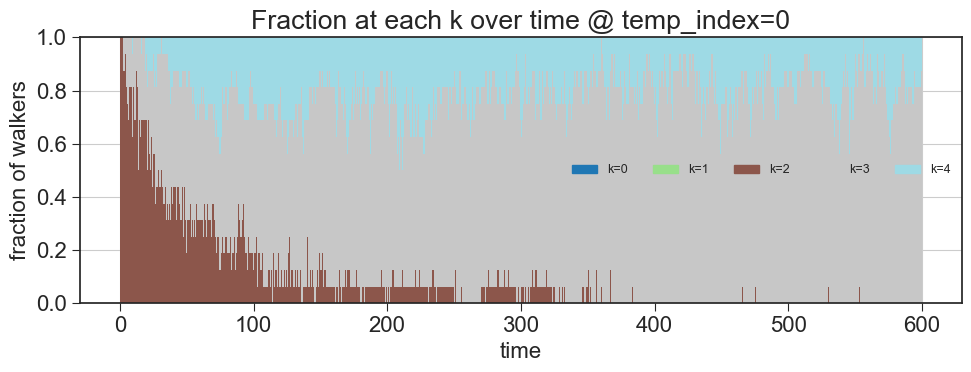

In [45]:
def build_timeline_segments(trace: RunTrace, temp_index: int = 0, thin_bd: int = 1, thin_mh: int = 1):
    """
    Returns:
      segments: list of dicts with keys:
        't0','t1','dt','k_per_w'  (k_per_w: (W,) ints for the chosen temperature)
    """
    W, Kmax = trace.W, trace.Kmax
    # unified timeline (BD + MH), states are AFTER each event
    bd_list = [(ev.t_abs, 0, i) for i, ev in enumerate(trace.bd_events)][::thin_bd]
    mh_list = [(tick.t_abs, 1, i) for i, tick in enumerate(trace.mh_ticks)][::thin_mh]
    all_ev = bd_list + mh_list
    if not all_ev:
        return []

    all_ev.sort(key=lambda x: x[0])
    T = total_time_from_trace(trace)

    def get_state(kind, idx):
        if kind == 0:   # BD
            ev = trace.bd_events[idx]
            return ev.phi_sel, ev.m_sel
        else:           # MH
            tick = trace.mh_ticks[idx]
            res = _last_tick_state_snapshot(tick)   # (phi_sel, m_sel) or None
            if res is None: return None, None
            return res

    segments = []
    for i, (t_abs, kind, idx) in enumerate(all_ev):
        phi_sel, m_sel = get_state(kind, idx)
        if phi_sel is None:   # skip ticks without snapshots
            continue

        t0 = t_abs
        t1 = all_ev[i+1][0] if i+1 < len(all_ev) else T
        dt = max(0.0, t1 - t0)
        if dt <= 0.0:
            continue

        m_c = m_sel[temp_index]             # (W, Kmax)
        k_per_w = m_c.sum(axis=1).astype(int)  # (W,)
        segments.append(dict(t0=t0, t1=t1, dt=dt, k_per_w=k_per_w))
    return segments


def plot_fraction_at_k_over_time(trace: RunTrace, temp_index: int = 0, thin_bd: int = 1, thin_mh: int = 1):
    segs = build_timeline_segments(trace, temp_index, thin_bd, thin_mh)
    if not segs:
        print("No segments to plot."); return
    W, Kmax = trace.W, trace.Kmax

    # Build stepwise time grid and fractions
    t_edges = [segs[0]['t0']] + [s['t1'] for s in segs]   # len = S+1
    # counts[k, s] = number of walkers at k on segment s
    counts = np.zeros((Kmax+1, len(segs)), dtype=float)
    for s_idx, s in enumerate(segs):
        ks = s['k_per_w']   # (W,)
        binc = np.bincount(ks, minlength=Kmax+1)
        counts[:, s_idx] = binc

    fracs = counts / float(W)   # (Kmax+1, S)

    # Convert to step values (repeat each segment value at both edges)
    x = np.repeat(np.array(t_edges), 1)  # step edges
    # for stackplot we want values per "x point"; simplest: draw stacked *steps* via fill_between
    fig, ax = plt.subplots(figsize=(10, 4))
    cum = np.zeros(len(segs))
    colors = plt.cm.tab20(np.linspace(0,1,Kmax+1)) if Kmax <= 20 else plt.cm.viridis(np.linspace(0,1,Kmax+1))
    for k in range(Kmax+1):
        y = fracs[k]                  # (S,)
        # draw as step by duplicating along edges
        x_step = np.array([segs[0]['t0']]) + np.cumsum([0] + [segs[i]['dt'] for i in range(len(segs))])
        xL = x_step[:-1]; xR = x_step[1:]
        # rectangles per segment
        for s_idx in range(len(segs)):
            ax.fill_between([xL[s_idx], xR[s_idx]], cum[s_idx], cum[s_idx] + y[s_idx],
                            step='post', color=colors[k], linewidth=0)
        cum += y

    ax.set_ylim(0,1)
    ax.set_xlabel("time"); ax.set_ylabel("fraction of walkers")
    ax.set_title(f"Fraction at each k over time @ temp_index={temp_index}")
    patches = [mpl.patches.Patch(color=colors[k], label=f'k={k}') for k in range(Kmax+1)]
    ax.legend(handles=patches, ncol=min(6, Kmax+1), fontsize=9, frameon=False)
    plt.tight_layout()

plot_fraction_at_k_over_time(results, temp_index=temp_idx)
plt.show()

In [46]:


def scatter_ll_over_time_by_k(
    trace,
    temp_index: int = 0,
    thin_mh: int = 1,
    reconstruct_if_missing: bool = True,
    log_prior_phi_np=None,
    log_pseudo_phi_np=None,
    log_p_k_np=None,
):
    """
    Scatter of masked log-likelihood vs time, colored by k, using the LAST submove snapshot per MH tick.
    If ll_sel is missing on snapshots and reconstruct_if_missing=True, reconstruct ll from logpi_sel.
    """
    xs, ys, cs = [], [], []

    Kmax = int(trace.Kmax)
    # β at this temperature (using the same mapping as elsewhere in your code)
    beta = float(trace.betas[trace.chain_inds[temp_index]])

    for i_tick, tick in enumerate(trace.mh_ticks[::thin_mh]):
        snaps = getattr(tick, "submoves", None)
        if not snaps:
            continue
        snap = snaps[-1]  # "last" snapshot policy

        # required pieces from the snapshot
        phi_sel = getattr(snap, "phi_sel", None)
        m_sel   = getattr(snap, "m_sel", None)
        if phi_sel is None or m_sel is None:
            continue

        phi_c = phi_sel[temp_index]        # (W, Kmax, d)
        m_c   = m_sel[temp_index]          # (W, Kmax)
        k_c   = m_c.sum(axis=1).astype(int)

        # prefer ll saved on the snapshot if present
        ll_c = getattr(snap, "ll_sel", None)
        if ll_c is not None:
            ll_c = ll_c[temp_index]        # (W,)
        else:
            # try to reconstruct: logpi = comb + comp + β * ll  ⇒ ll = (logpi - comb - comp)/β
            if reconstruct_if_missing:
                logpi_sel = getattr(snap, "logpi_sel", None)
                ok = (logpi_sel is not None and
                      log_prior_phi_np is not None and
                      log_pseudo_phi_np is not None and
                      log_p_k_np is not None and beta > 0)
                if not ok:
                    # cannot reconstruct for this tick; skip
                    continue

                W = phi_c.shape[0]
                # comp(w) = sum_i [ log p(φ_i) if m_i else log ψ(φ_i) ]
                comp = np.zeros((W,), dtype=float)
                for i in range(Kmax):
                    for w in range(W):
                        comp[w] += (log_prior_phi_np(phi_c[w, i])
                                    if m_c[w, i] else log_pseudo_phi_np(phi_c[w, i]))

                k_w = m_c.astype(int).sum(axis=1)  # (W,)
                comb = (log_p_k_np(k_w)
                        + _log_uniform_masks_given_k(Kmax, k_w)
                        + _log_symmetrization(k_w))

                logpi_c = logpi_sel[temp_index]  # (W,)
                ll_c = (logpi_c - comb - comp) / max(beta, 1e-12)
            else:
                continue

        xs.extend([tick.t_abs] * len(ll_c))
        ys.extend(ll_c.tolist())
        cs.extend(k_c.tolist())

    if not xs:
        print("No ll found in submove snapshots (and reconstruction disabled or impossible).")
        return

    # plotting
    cmap = mpl.colormaps['tab20'] if Kmax <= 20 else mpl.colormaps['viridis']
    norm = mpl.colors.BoundaryNorm(boundaries=np.arange(-0.5, Kmax + 1.5, 1.0), ncolors=cmap.N)

    plt.figure(figsize=(10, 4))
    sc = plt.scatter(xs, ys, c=cs, s=10, alpha=0.6, cmap=cmap, norm=norm)
    cbar = plt.colorbar(sc, ticks=range(Kmax + 1))
    cbar.set_label("k")
    plt.xlabel("time")
    plt.ylabel("masked log-likelihood")
    plt.title(f"MH snapshots (last per tick): ll vs time @ temp_index={temp_index}")
    plt.tight_layout()



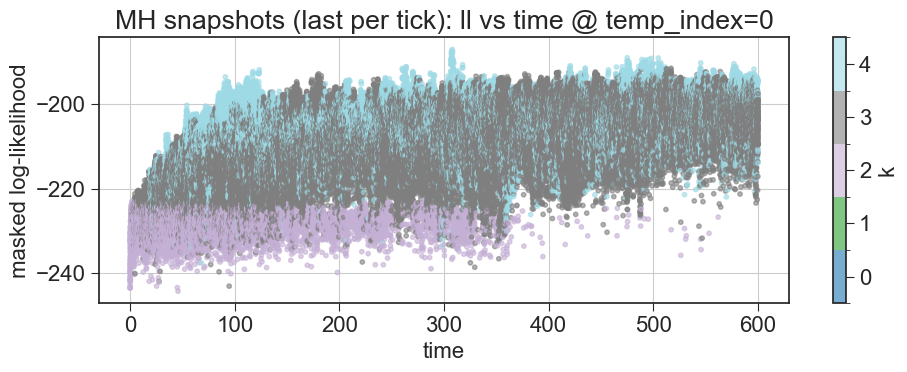

In [47]:
scatter_ll_over_time_by_k(results, temp_index=temp_idx, thin_mh=1, reconstruct_if_missing=False)

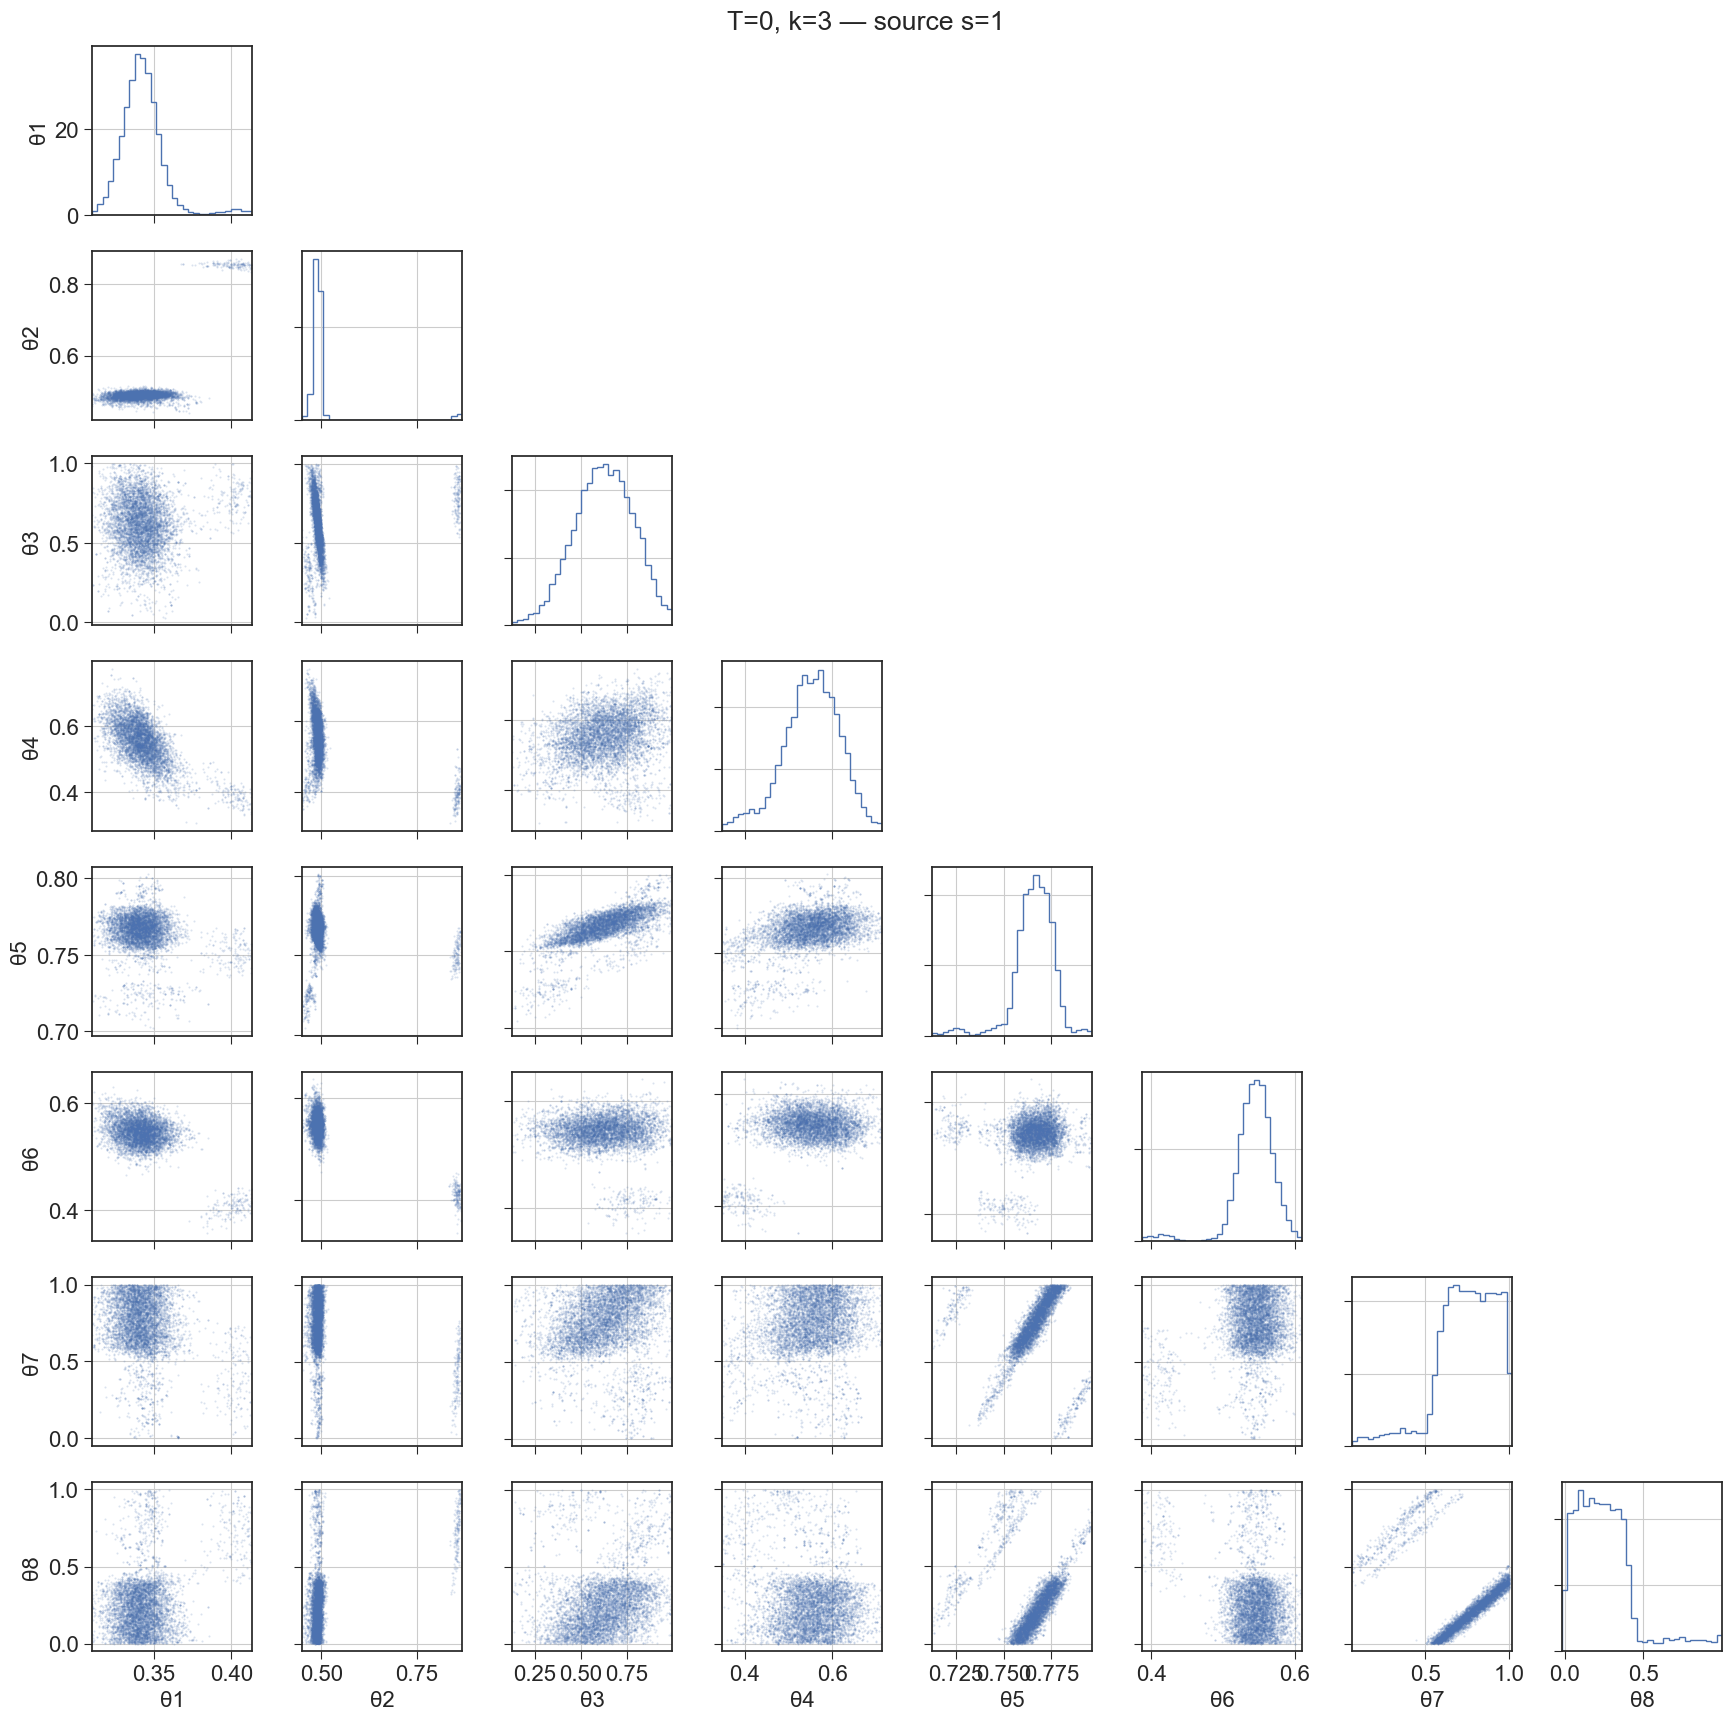

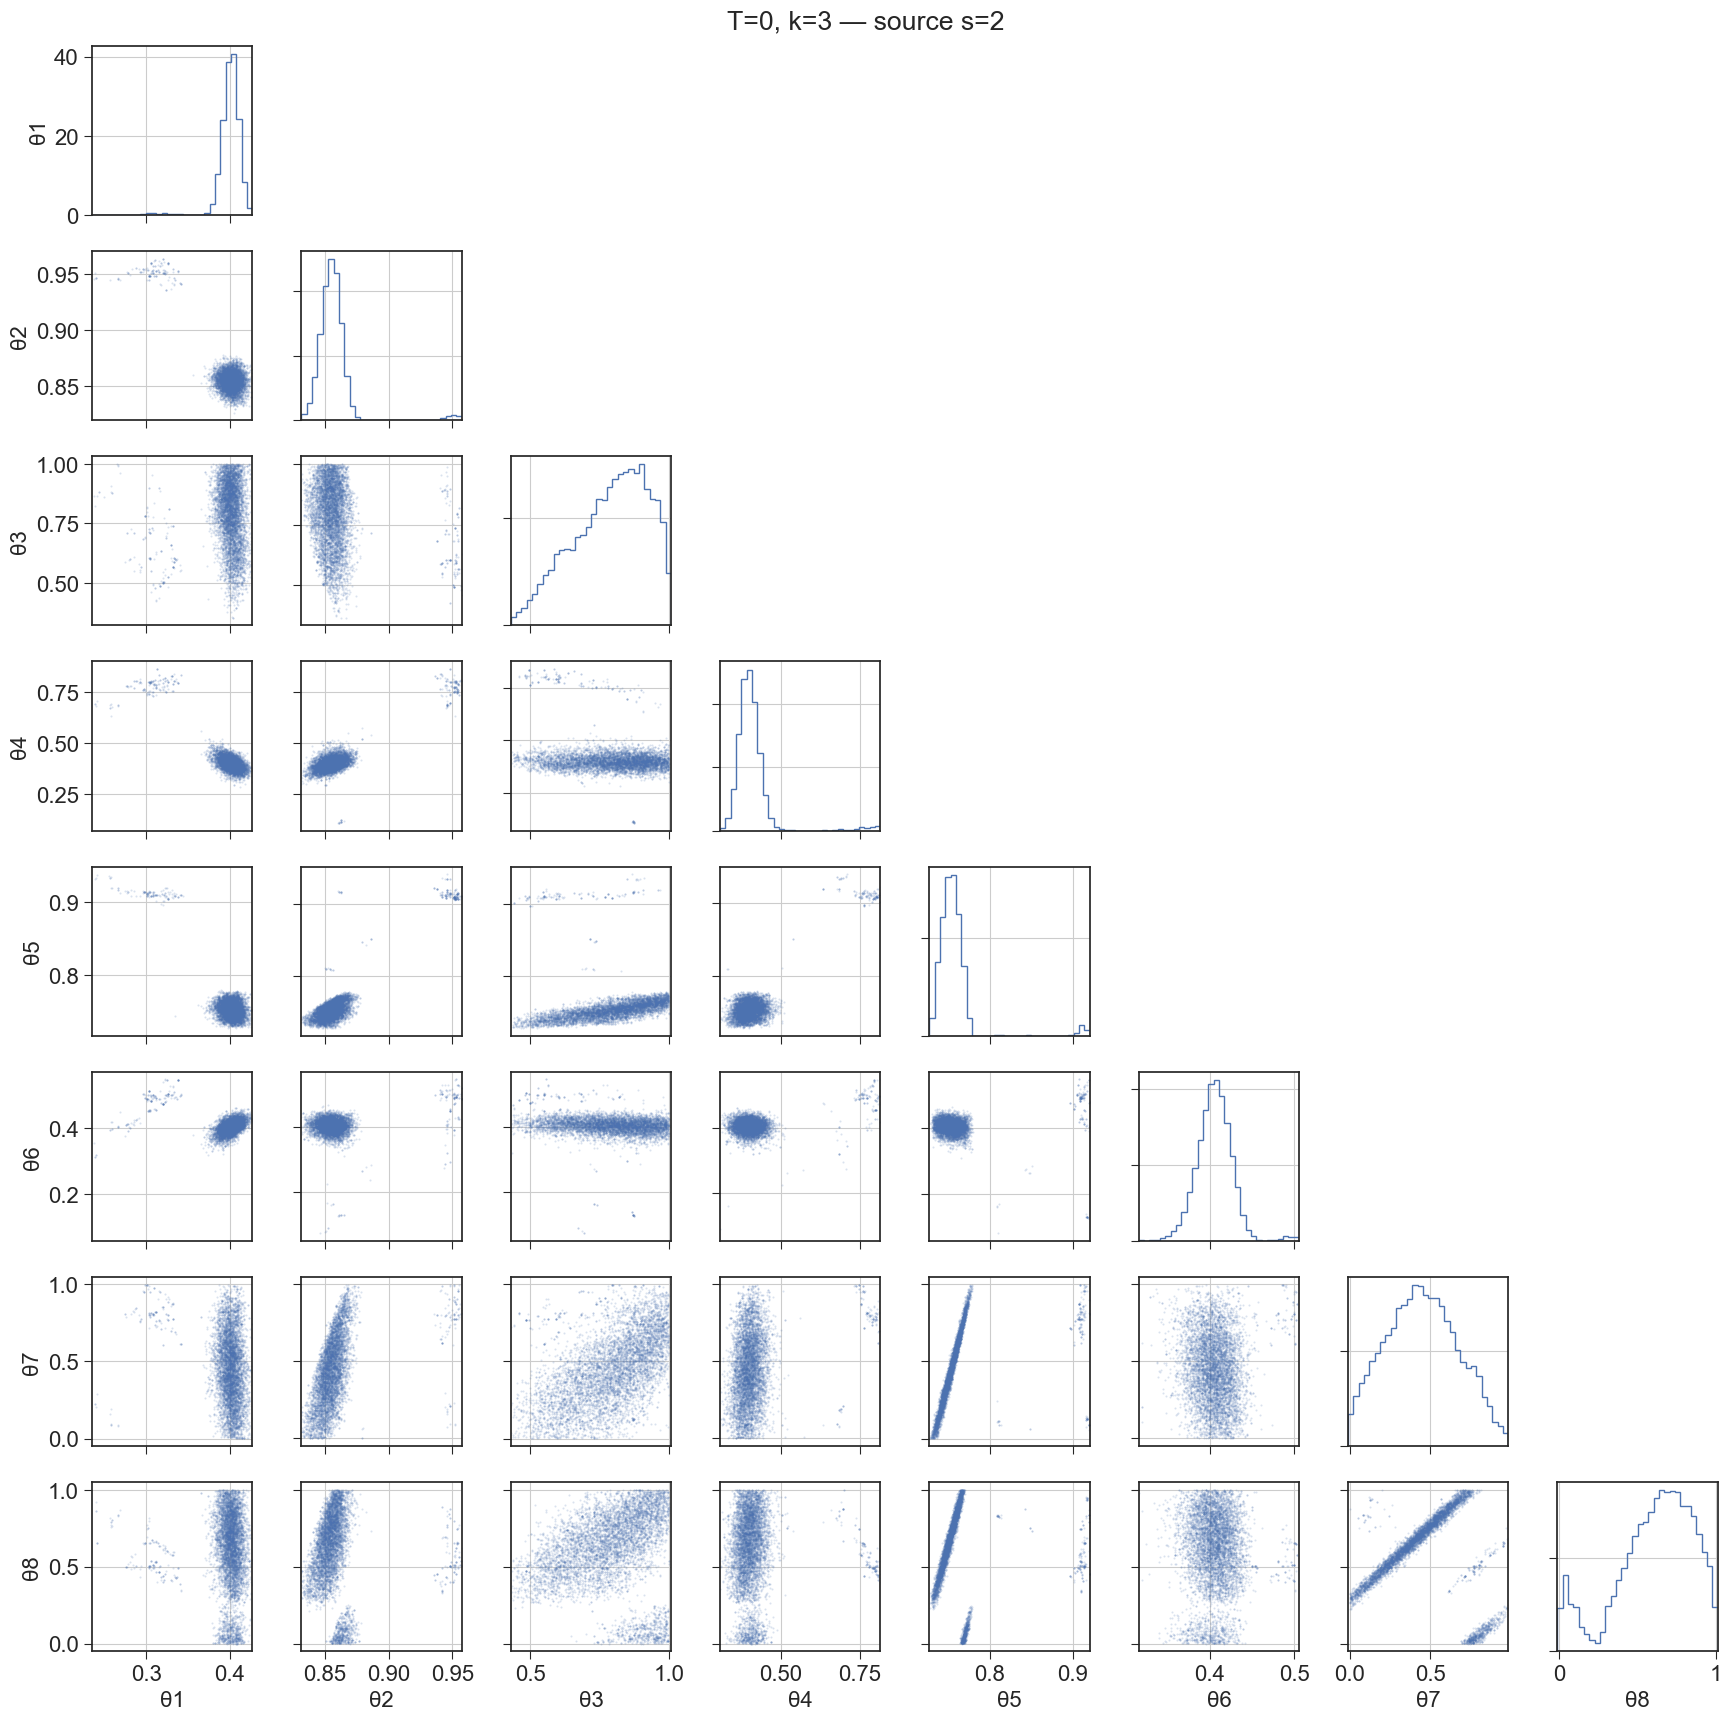

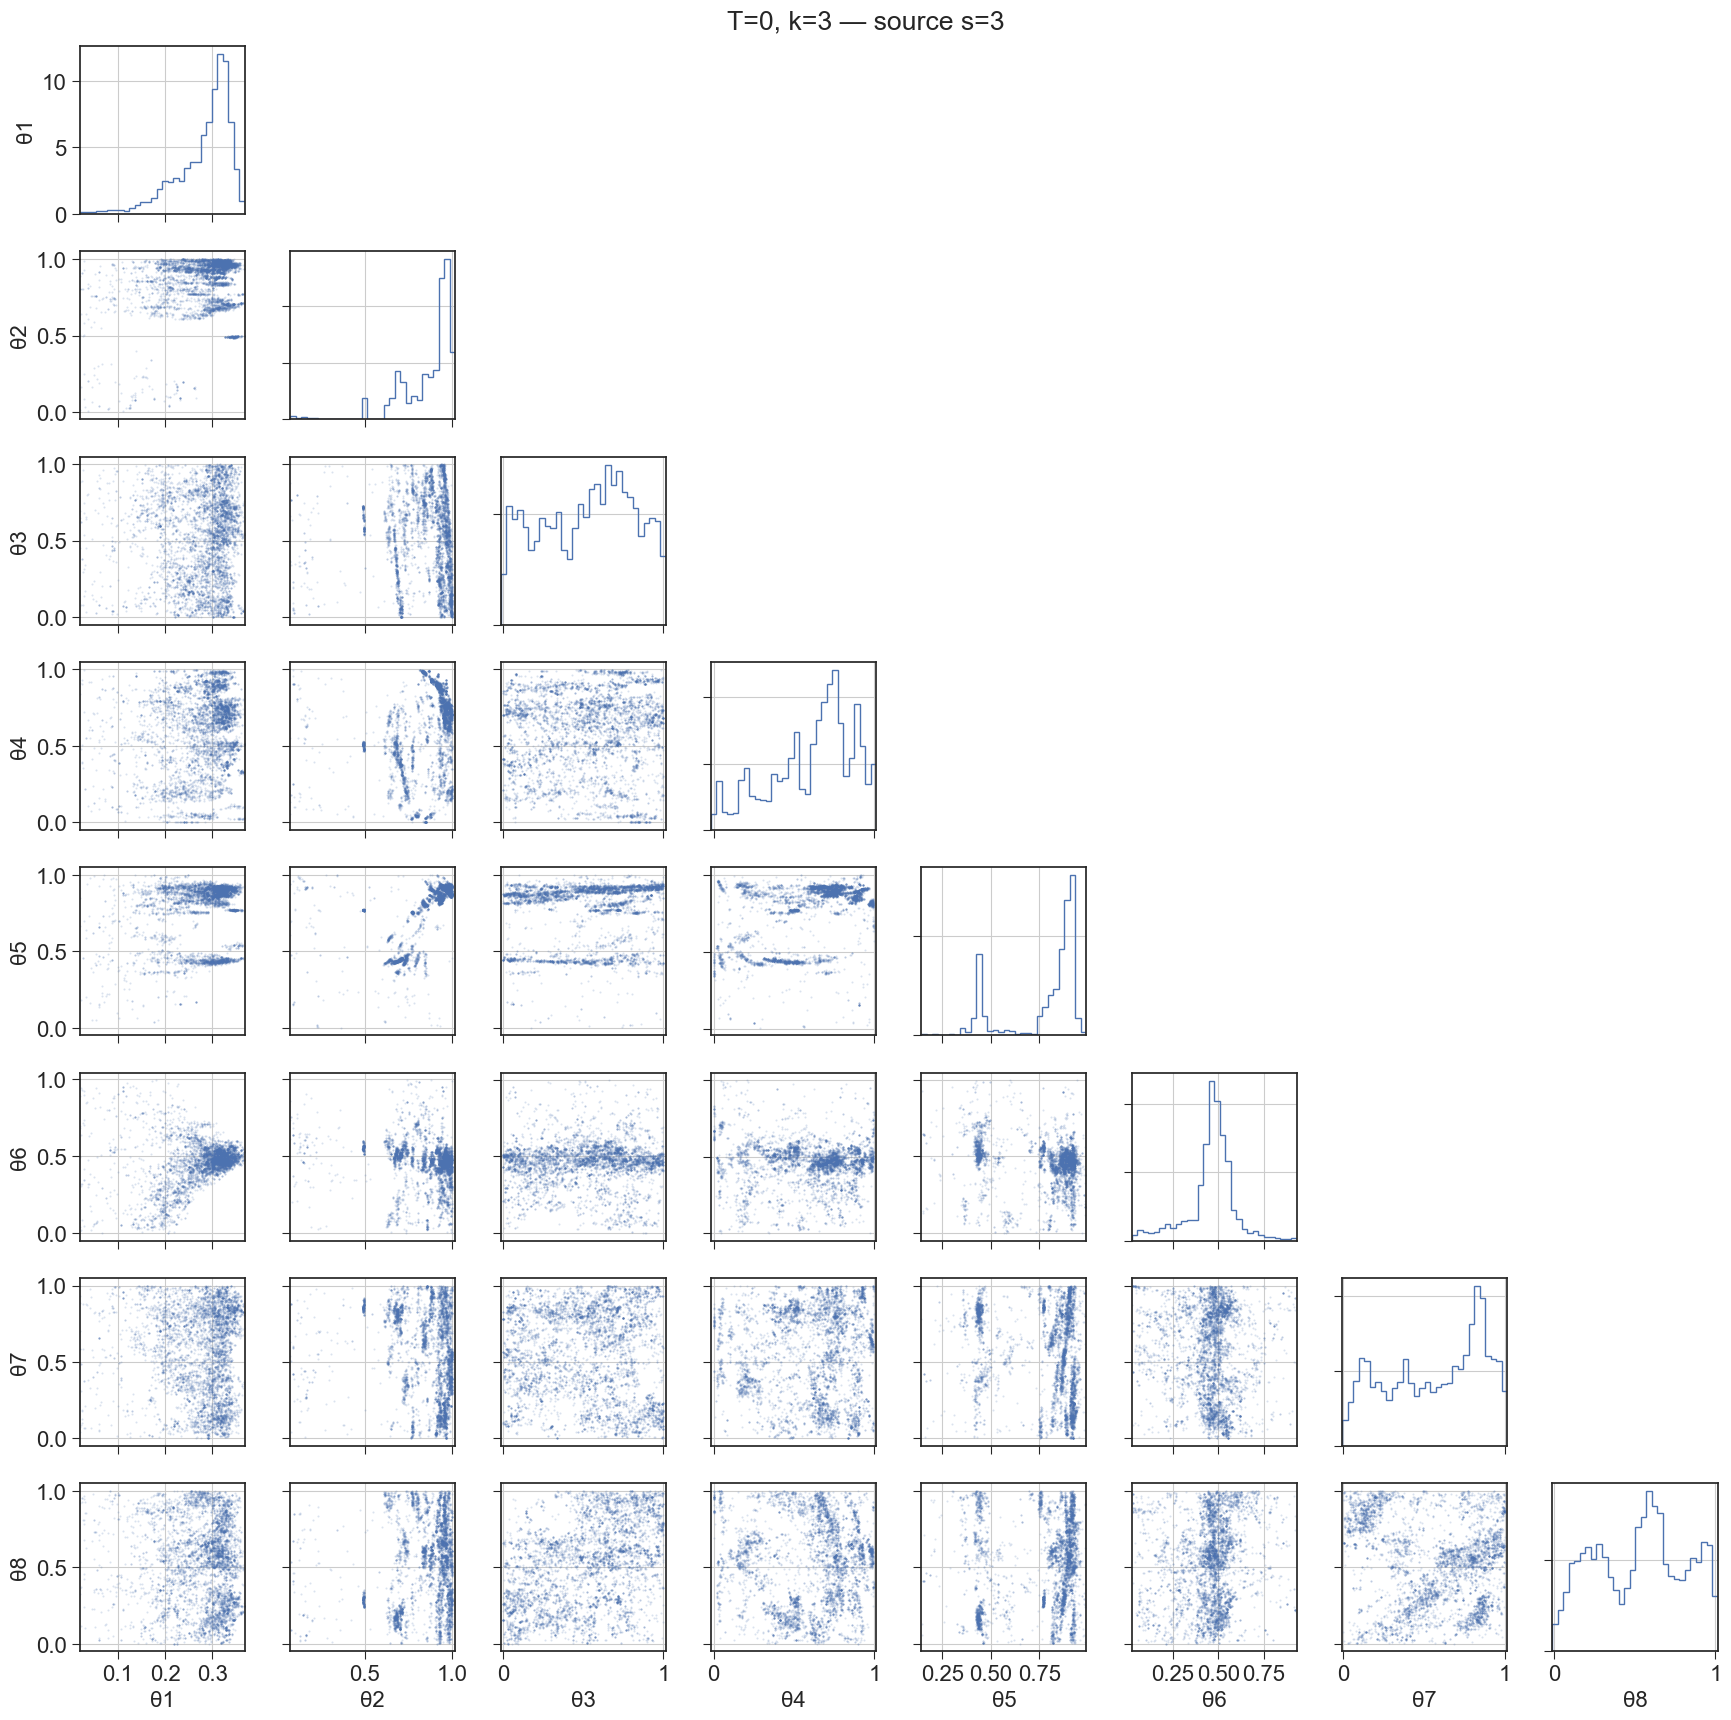

In [19]:

# --- 1) Lower-triangular weighted corner plot --------------------------------
def _compute_xlims_per_dim(X: np.ndarray,
                           quantile_clip: Optional[Tuple[float, float]] = (0.005, 0.995)
                           ) -> List[Tuple[float, float]]:
    """
    For each dimension p, compute (xmin, xmax).
    If quantile_clip is provided, use those quantiles for robustness; else min/max.
    """
    N, P = X.shape
    xlims = []
    for p in range(P):
        xp = X[:, p]
        xp = xp[np.isfinite(xp)]
        if xp.size == 0:
            xlims.append((0.0, 1.0))
            continue
        if quantile_clip is None:
            lo, hi = float(np.min(xp)), float(np.max(xp))
        else:
            qlo, qhi = quantile_clip
            lo, hi = np.quantile(xp, [qlo, qhi])
        if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
            lo, hi = float(np.min(xp)), float(np.max(xp))
            if lo == hi:
                lo, hi = lo - 1.0, hi + 1.0
        # small padding
        pad = 0.02 * (hi - lo)
        xlims.append((lo - pad, hi + pad))
    return xlims


# --- Lower-triangular weighted corner with shared x per column ---
def plot_corner_lower_weighted(X: np.ndarray,
                               w: Optional[np.ndarray] = None,
                               labels: Optional[List[str]] = None,
                               bins: int = 30,
                               max_scatter: int = 6000,
                               suptitle: str = "",
                               quantile_clip: Optional[Tuple[float, float]] = (0.005, 0.995)
                               ) -> Tuple[plt.Figure, np.ndarray]:
    """
    Lower-triangular corner plot (diagonal = weighted hist, lower = scatter).
    All panels in column j share the same x-limits (and diagonal hist uses the same range).
    X: (N, P) samples
    w: (N,) optional weights
    """
    X = np.asarray(X)
    N, P = X.shape

    # normalize weights (if any) and guard against zeros
    if w is not None:
        w = np.asarray(w, float)
        s = w.sum()
        if s > 0:
            w = w / s
        else:
            w = None

    # precompute per-dimension x-limits
    xlims = _compute_xlims_per_dim(X, quantile_clip=quantile_clip)

    fig, axes = plt.subplots(P, P, figsize=(2.2*P, 2.2*P))
    for i in range(P):
        for j in range(P):
            ax = axes[i, j]
            if i < j:
                ax.axis("off")
                continue

            # set shared x-limits for this column j
            ax.set_xlim(*xlims[j])

            if i == j:
                # diagonal: histogram with the same range
                ax.hist(X[:, i], bins=bins, weights=w, density=True,
                        histtype="step", range=xlims[i])
            else:
                # lower triangle: scatter; downsample (weighted if provided)
                if max_scatter and N > max_scatter:
                    if w is None:
                        idx = np.random.choice(N, size=max_scatter, replace=False)
                    else:
                        # safe sampling: fall back to uniform if all weights are zero/NaN
                        p = w.copy()
                        if not np.isfinite(p).all() or p.sum() <= 0:
                            p = None
                        idx = np.random.choice(N, size=max_scatter, replace=False, p=p)
                else:
                    idx = slice(None)
                ax.plot(X[idx, j], X[idx, i], ".", ms=1.0, alpha=0.2)

            # tidy ticks
            if i < P-1:
                ax.set_xticklabels([])
            if j > 0:
                ax.set_yticklabels([])

            # labels
            if labels:
                if i == P-1 and j <= i:
                    ax.set_xlabel(labels[j])
                if j == 0 and i >= j:
                    ax.set_ylabel(labels[i])

    if suptitle:
        fig.suptitle(suptitle)
    fig.tight_layout()
    return fig, axes


# --- One corner per source (inherits the shared-x behavior) ---
def plot_per_source_corners(trace,
                            k: int,
                            temp_index: int = 0,
                            relabel_fn=None,
                            bins: int = 30,
                            max_scatter: int = 6000,
                            max_sources: int = 4,
                            quantile_clip: Optional[Tuple[float, float]] = (0.005, 0.995)
                            ) -> List[Tuple[plt.Figure, np.ndarray]]:
    """
    For fixed k: draw up to 'max_sources' separate corner plots (one per source),
    each over that source's d parameters. X-axis sharing is applied within each figure.
    """
    Xk, wk = posterior_samples_for_k(trace, k=k, temp_index=temp_index)  # (N,k,d), (N,)
    figs = []
    if Xk.shape[0] == 0:
        print(f"No samples for k={k} at temp idx {temp_index}")
        return figs

    if relabel_fn is not None:
        Xk = np.stack([relabel_fn(x) for x in Xk], axis=0)

    Ctemp = int(trace.chain_inds[temp_index])
    d = trace.d
    labels = [f"θ{j+1}" for j in range(d)]
    n_src = min(k, max_sources)

    for s in range(n_src):
        Xs = Xk[:, s, :]  # (N, d)
        title = f"T={Ctemp}, k={k} — source s={s+1}"
        fig, axes = plot_corner_lower_weighted(
            Xs, w=wk, labels=labels, bins=bins, max_scatter=max_scatter,
            suptitle=title, quantile_clip=quantile_clip
        )
        figs.append((fig, axes))

    if k > max_sources:
        print(f"(Only plotted first {max_sources} sources out of k={k}.)")
    return figs

plot_per_source_corners(results, k=3, temp_index=0)
plt.show()

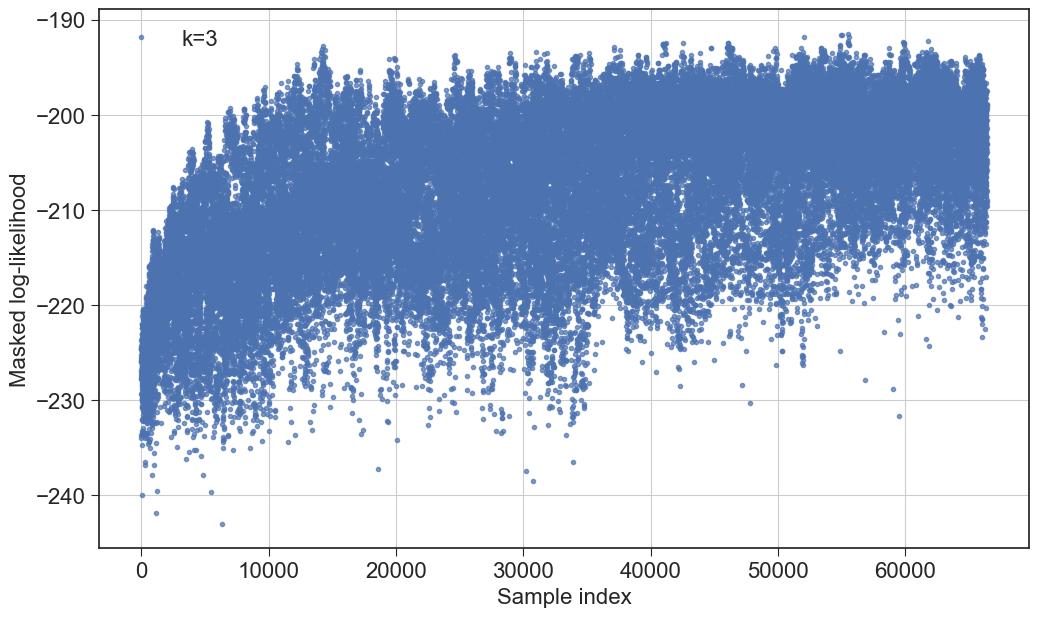

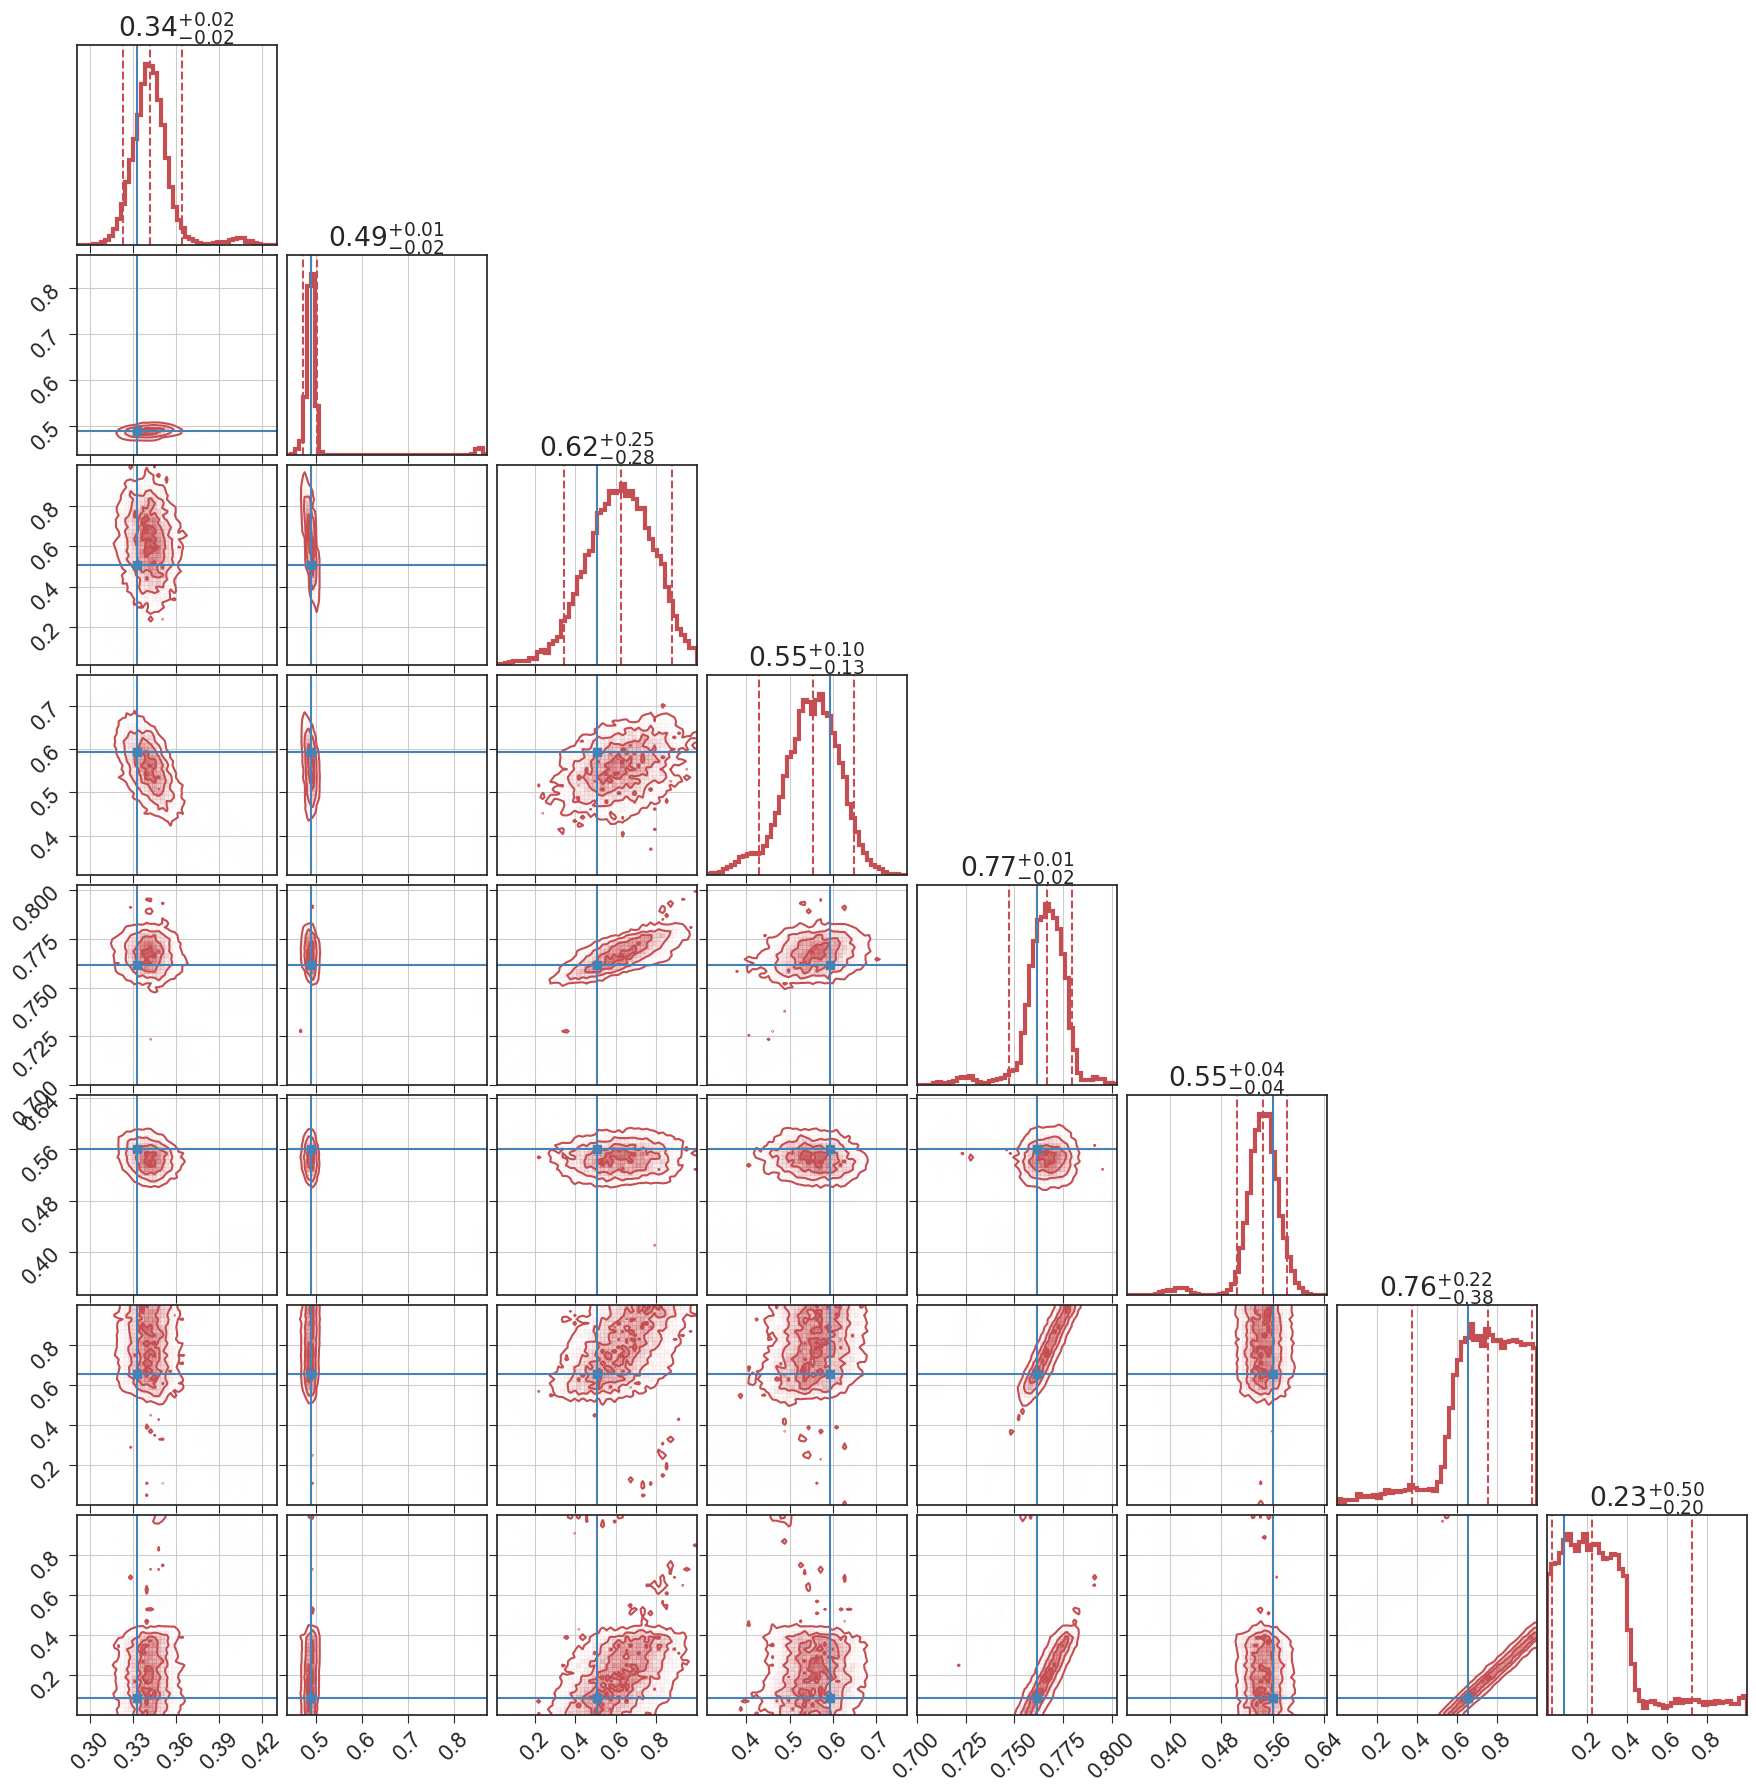

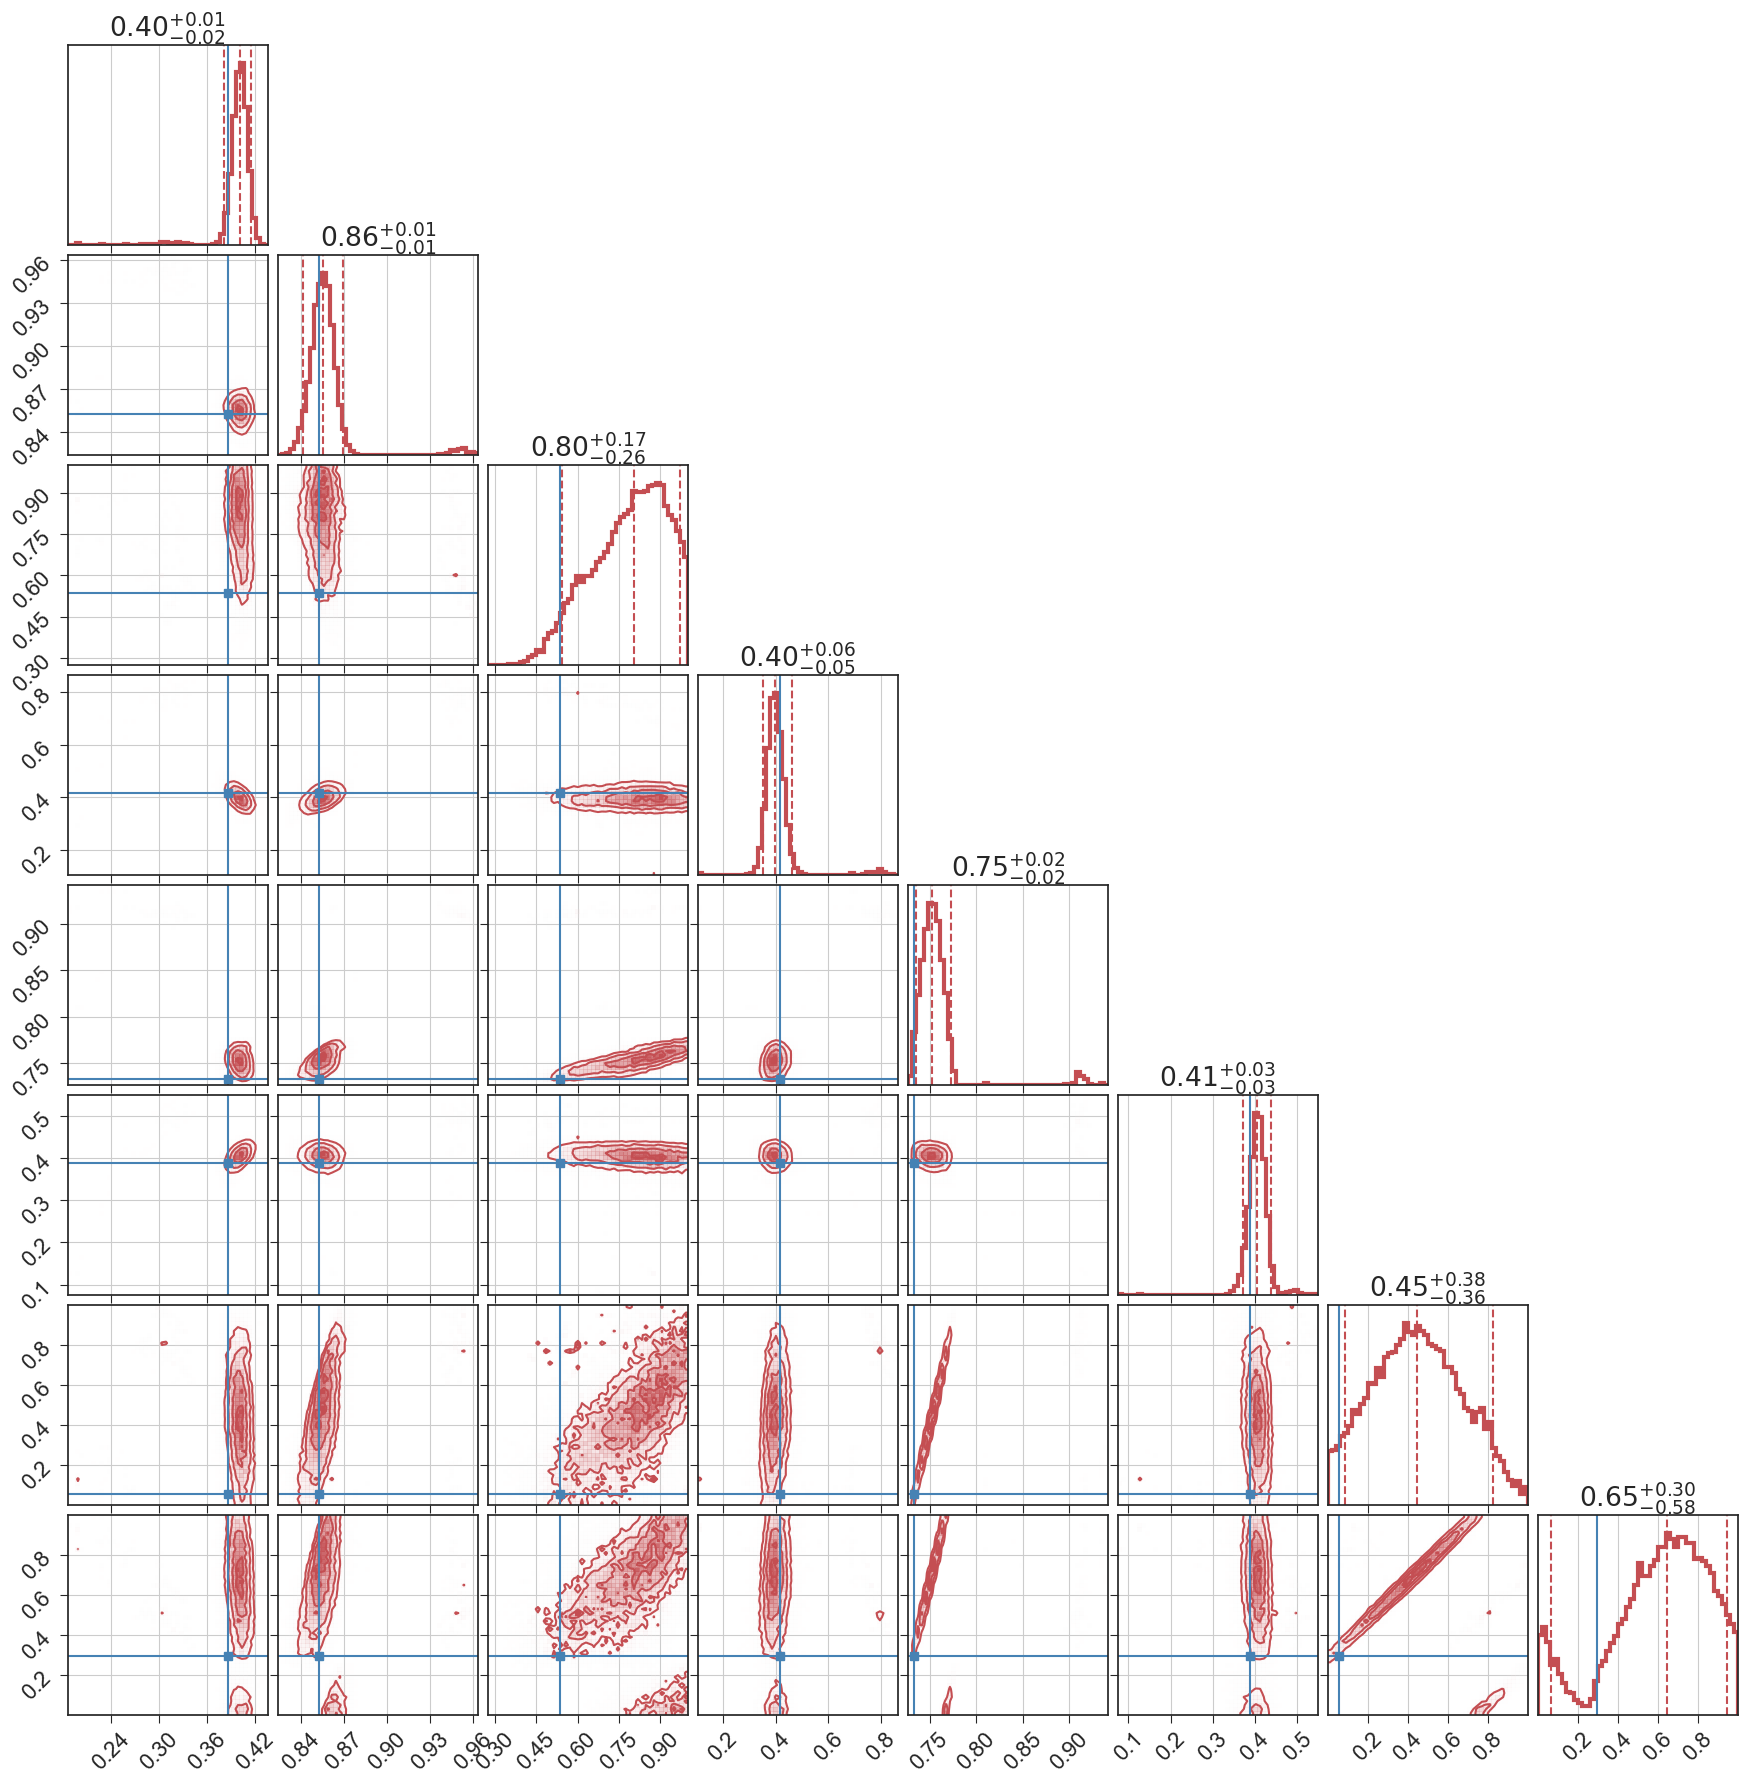

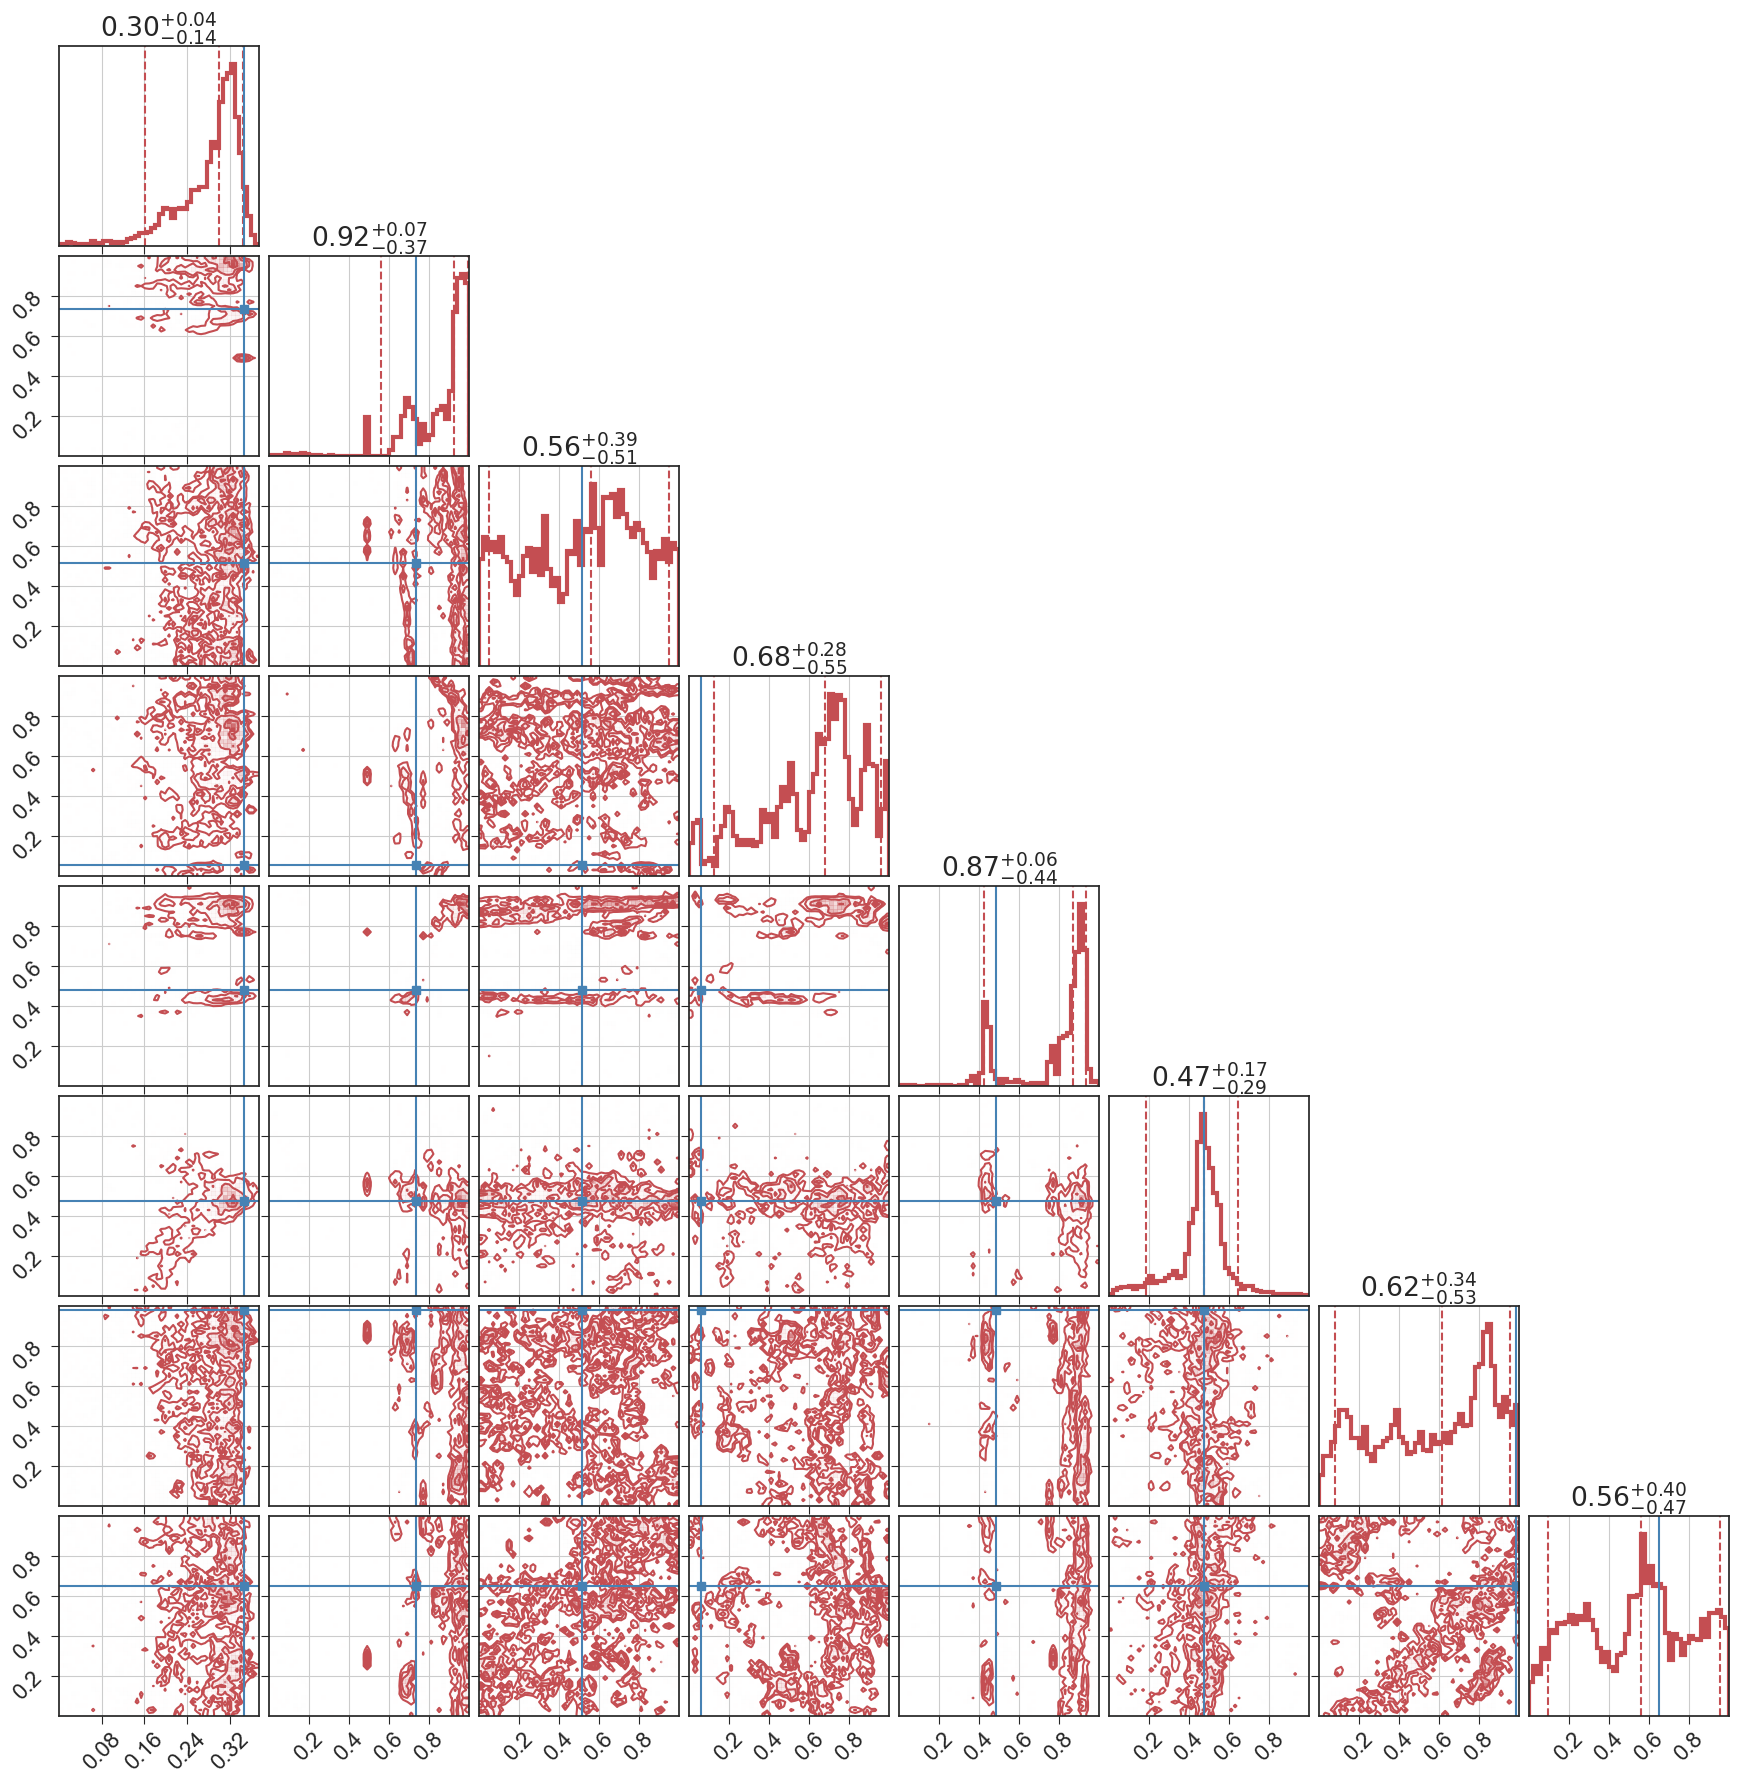

(66408, 24)


In [17]:

import matplotlib.lines as mlines

start = 0
thin =1

k_cur = 3

Xk, wk, ll, logpi = posterior_samples_for_k_with_scores(results, k=k_cur, temp_index=temp_idx,
                                                           include_mh=True, include_bd=False,
                                                           weight_by="dt", 
                                                        #    mh_snapshot_policy="accepted_only",
                                                           mh_snapshot_policy="last",
                                                         #   mh_snapshot_policy="all",
                                                           mh_skip_first=10)



plt.plot(ll, '.',  alpha=0.7, label='k='+str(k_cur))
# plt.ylim(-500, -180)
plt.legend()
plt.xlabel('Sample index')
plt.ylabel('Masked log-likelihood')
plt.show() 


fig300 = corner.corner(Xk[start::thin, 0, :], weight=wk[start::thin], bins=50, hist_kwargs={'density':True, 'lw':3}, 
                    plot_datapoints=False, fill_contours=False, quantiles=[0.05, 0.5, 0.95],
                    show_titles=True, color='C2', use_math_test=True, truths=_srcHC245[:8]) 

# corner.corner(samples0[:, :8], fig=fig300,bins=50, hist_kwargs={'density':True, 'lw':3},
#               plot_datapoints=False, fill_contours=False, quantiles=[0.05, 0.5, 0.95],
#               # show_titles=True, color='C1', use_math_test=True, truths=_srcHC245[:8])

# line1 = mlines.Line2D([], [], color='C1', label='eryn')
# line2 = mlines.Line2D([], [], color='C2', label='my')

# Add the legend to the figure
# fig300.legend(handles=[line1, line2], loc='upper right', fontsize=20)


fig310 = corner.corner(Xk[start::thin, 1, :], weight=wk[start::thin], bins=50, hist_kwargs={'density':True, 'lw':3}, 
                    plot_datapoints=False, fill_contours=False, quantiles=[0.05, 0.5, 0.95],
                    show_titles=True, color='C2', use_math_test=True, truths=_srcHC245[8:16]  ) 


# corner.corner(samples0[:, 8:16], fig=fig310, bins=50, hist_kwargs={'density':True, 'lw':3},
#               plot_datapoints=False, fill_contours=False, quantiles=[0.05, 0.5, 0.95],
#               show_titles=True, color='C1', use_math_test=True, truths=_srcHC245[8:16])



fig320 = corner.corner(Xk[start::thin, 2, :], weight=wk[start::thin], bins=50, hist_kwargs={'density':True, 'lw':3}, 
                    plot_datapoints=False, fill_contours=False, quantiles=[0.05, 0.5, 0.95],
                    show_titles=True, color='C2', use_math_test=True, truths=_srcHC245[16:24]) 

# corner.corner(samples0[:, 16:24], fig=fig320, bins=50, hist_kwargs={'density':True, 'lw':3},
#               plot_datapoints=False, fill_contours=False, quantiles=[0.05, 0.5, 0.95],
#               show_titles=True, color='C1', use_math_test=True, truths=_srcHC245[16:24])

 
plt.show()

Xk_reshaped = Xk.reshape(Xk.shape[0], -1)
print (Xk_reshaped.shape)
cov_k3 = np.cov(Xk_reshaped, rowvar=False)
np.save('cov_k3.npy', cov_k3)



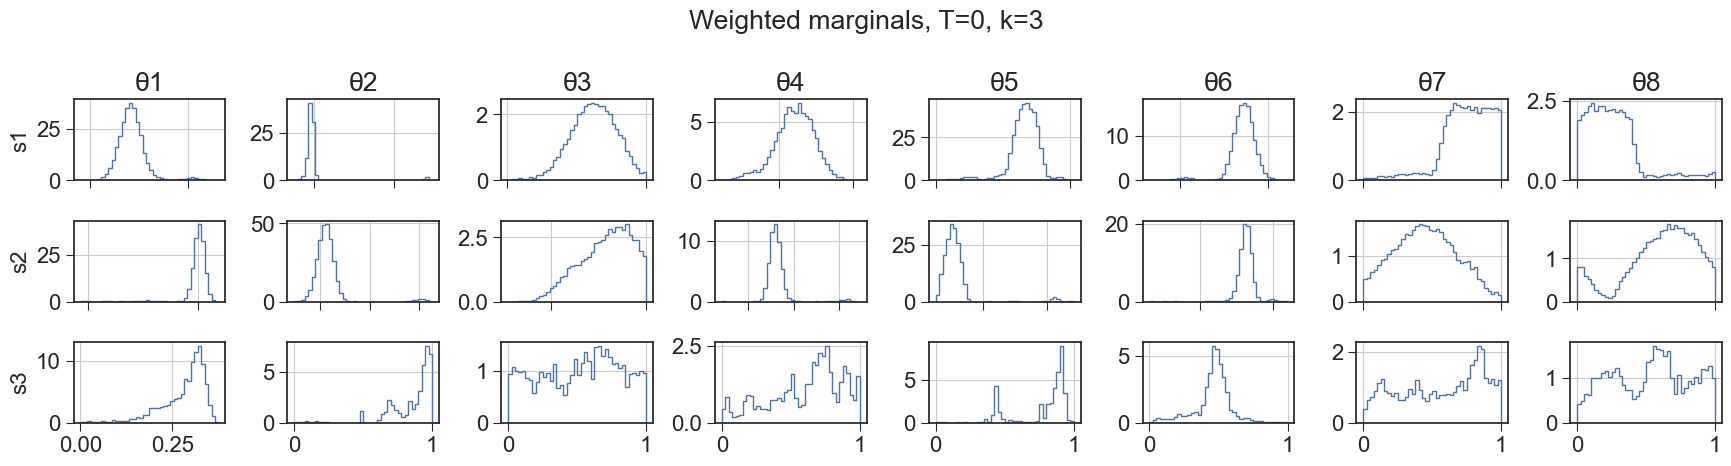

In [20]:
def plot_marginals_for_k(trace: RunTrace, k: int, temp_index: int = 0, bins: int = 40):
    Xk, wk = posterior_samples_for_k(trace, k=k, temp_index=temp_index)  # (N,k,d)
    if Xk.shape[0] == 0:
        print(f"No samples for k={k} at temp idx {temp_index}")
        return
    N, kk, d = Xk.shape
    assert kk == k
    fig, axes = plt.subplots(k, d, figsize=(2.2*d, 1.6*k), squeeze=False)
    for si in range(k):
        for dj in range(d):
            ax = axes[si, dj]
            ax.hist(Xk[:, si, dj], bins=bins, weights=wk, density=True, histtype="step")
            if si == 0:
                ax.set_title(f"θ{dj+1}")
            if dj == 0:
                ax.set_ylabel(f"s{si+1}")
            if si < k-1:
                ax.set_xticklabels([])
    fig.suptitle(f"Weighted marginals, T={int(trace.chain_inds[temp_index])}, k={k}")
    fig.tight_layout()
    return fig, axes

plot_marginals_for_k(results, k=3, temp_index=0)
plt.show()

p(k|y) at T0 (weighted): [0.         0.         0.0940562  0.70339772 0.20254607]
BF(2 vs 3) = 0.134
BF(2 vs 4) = 0.464
BF(3 vs 4) = 3.47
Bayes Factors BF(k1 vs k2) = [post odds / prior odds]:
  BF(2 vs 3) = 0.134
  BF(2 vs 4) = 0.464
  BF(3 vs 4) = 3.47


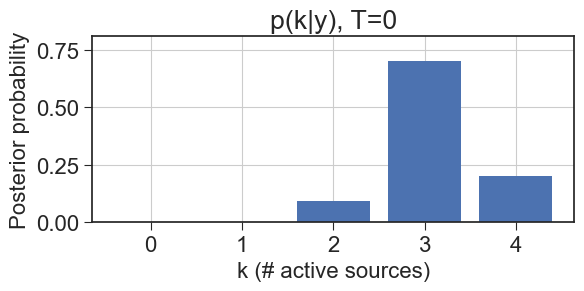

In [22]:
temp_label = int(results.chain_inds[temp_idx])

# Posterior over k (weighted)
post_k = posterior_over_k(results, temp_index=temp_idx, weighted=True)
print(f"p(k|y) at T{temp_label} (weighted):", post_k)

# (2) Bayes factors (flat prior unless you pass your p0(k))
BF = bayes_factors_from_postk(post_k)
for (k1,k2), v in sorted(BF.items()):
    print(f"BF({k1} vs {k2}) = {v:.3g}")

def plot_post_k_and_bayes(post_k: np.ndarray, prior_k: Optional[np.ndarray] = None, title: str = ""):
    ks = np.arange(len(post_k))
    fig, ax = plt.subplots(figsize=(6, 3.2))
    ax.bar(ks, post_k)
    ax.set_xlabel("k (# active sources)")
    ax.set_ylabel("Posterior probability")
    if title:
        ax.set_title(title)
    ax.set_xticks(ks)
    ax.set_ylim(0, max(0.05, post_k.max() * 1.15))
    fig.tight_layout()

    # Bayes Factors
    BF = bayes_factors_from_postk(post_k, prior_k=prior_k)
    print("Bayes Factors BF(k1 vs k2) = [post odds / prior odds]:")
    for (k1, k2), v in sorted(BF.items()):
        print(f"  BF({k1} vs {k2}) = {v:.3g}")

post_k = posterior_over_k(results, temp_index=temp_idx, weighted=True)
plot_post_k_and_bayes(post_k, title=f"p(k|y), T={int(results.chain_inds[temp_idx])}")

In [23]:
def bd_evolution(trace: RunTrace) -> Dict[int, Tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """
    Returns: dict temp_c -> (times, cum_births, cum_deaths)
    times is sorted unique BD times for that temp.
    """
    per_c = defaultdict(list)
    for ev in trace.bd_events:
        per_c[int(ev.c)].append((ev.t_abs, ev.kind))  # kind: 0=birth,1=death

    out = {}
    for c, evs in per_c.items():
        evs.sort()
        times = []
        cb, cd = [], []
        b = d = 0
        for t, kind in evs:
            times.append(t)
            if kind == 0: b += 1
            else:         d += 1
            cb.append(b); cd.append(d)
        out[c] = (np.array(times), np.array(cb), np.array(cd))
    return out

T0: last time=598, births=370, deaths=392
T3: last time=600, births=346, deaths=345
T5: last time=599, births=249, deaths=226


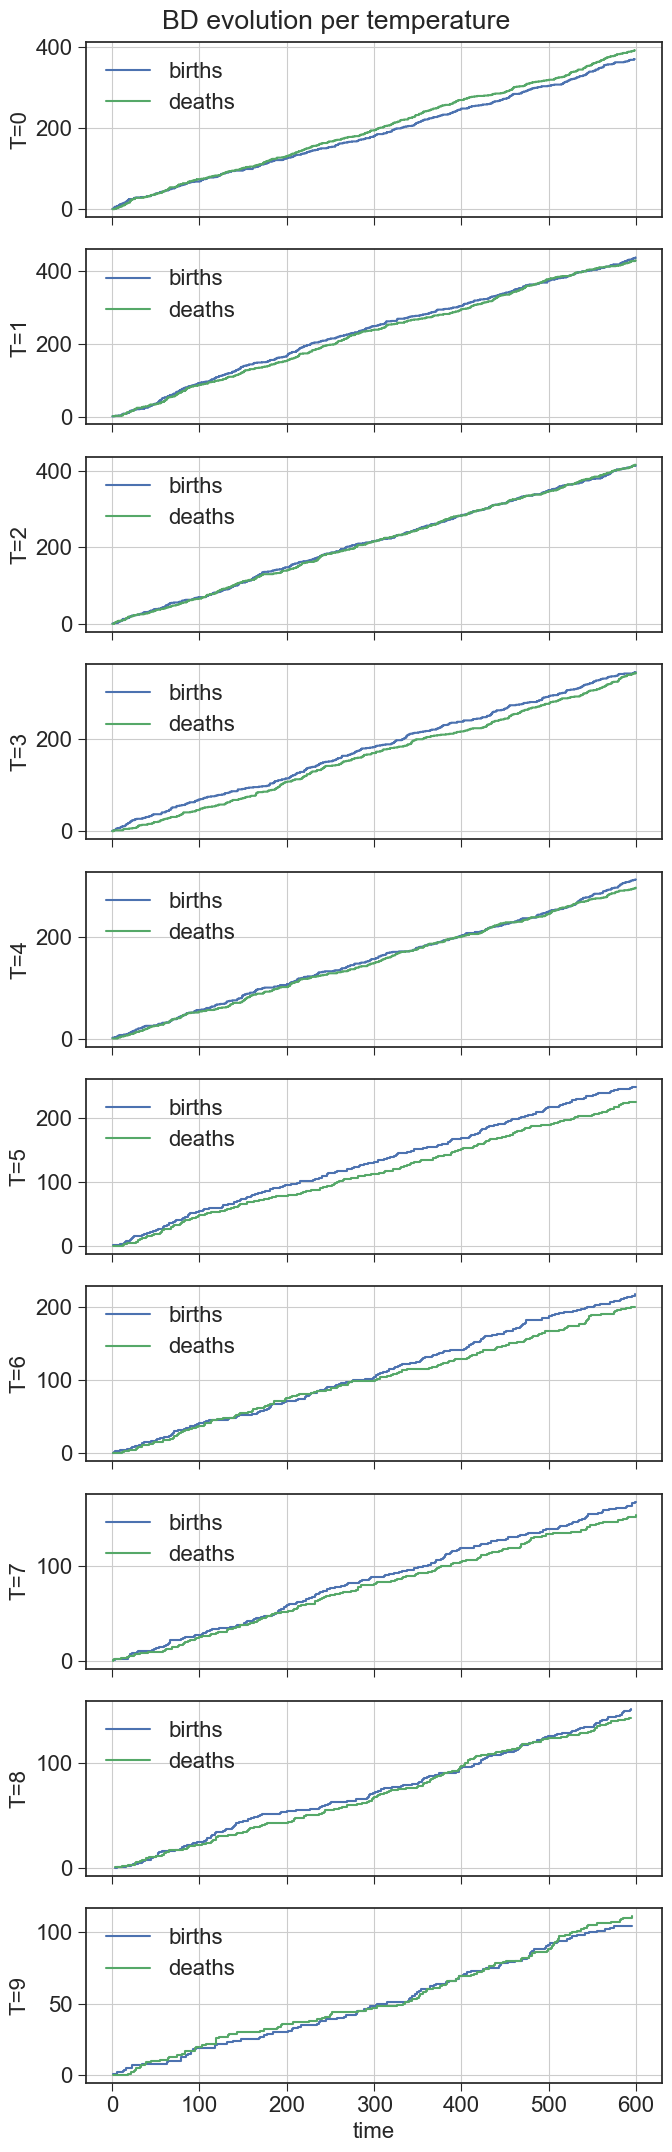

In [24]:
# (4) BD evolution in time
bd_time = bd_evolution(results)
for c in results.chain_inds:
    c = int(c)
    if c in bd_time:
        t, cb, cd = bd_time[c]
        print(f"T{c}: last time={t[-1]:.3g}, births={cb[-1]}, deaths={cd[-1]}")

def plot_bd_evolution_over_time(trace: RunTrace):
    bd_time = bd_evolution(trace)  # dict c -> (t, cum_births, cum_deaths)
    if not bd_time:
        print("No BD events recorded.")
        return
    n = len(bd_time)
    fig, axes = plt.subplots(n, 1, figsize=(7, 2.2*n), sharex=True)
    if n == 1: axes = [axes]
    for ax, (c, (t, cb, cd)) in zip(axes, sorted(bd_time.items())):
        ax.step(t, cb, where="post", label="births")
        ax.step(t, cd, where="post", label="deaths")
        ax.set_ylabel(f"T={c}")
        ax.legend(loc="best")
    axes[-1].set_xlabel("time")
    fig.suptitle("BD evolution per temperature")
    fig.tight_layout()
    return fig, axes

plot_bd_evolution_over_time(results)
plt.show()

In [25]:
def mh_acceptance_timeseries(events: BD_MH.EventLog, C: int) -> Dict[int, Dict[str, Tuple[np.ndarray, np.ndarray]]]:
    """
    Returns dict:
      c -> move_name -> (times, rates)
    where times are unique tick t_abs sorted, and rates are acceptance in that tick
    (accepted / attempted), pooled over walkers *within that temp and move type*.
    """
    # Group by tick time
    by_tick = defaultdict(list)
    for ev in events.mh_events:
        by_tick[ev.t_abs].append(ev)
    tick_times = sorted(by_tick.keys())

    # Build per-temp, per-move series
    per_c_move = {c: {m: ([], []) for m in ["stretch","rw_fullcov","rw_eigenline","rw_student_t","de","ptswap"]}
                  for c in range(C)}

    for t in tick_times:
        evs = by_tick[t]
        # aggregate (temp, move) -> (acc, att)
        agg = defaultdict(lambda: [0,0])
        for ev in evs:
            key = (ev.c, ev.move_type)
            agg[key][1] += 1
            if ev.accepted: agg[key][0] += 1
        for (c, move), (ok, tot) in agg.items():
            per_c_move[c][move][0].append(t)
            per_c_move[c][move][1].append((ok / tot) if tot > 0 else np.nan)


    # convert to arrays
    out = {}
    for c in range(C):
        cm = {}
        for move, (ts, rs) in per_c_move[c].items():
            if ts:
                order = np.argsort(ts)
                cm[move] = (np.array(ts)[order], np.array(rs)[order])
        out[c] = cm
    return out

T0 acceptance series:
  stretch: 5877 ticks, mean acc=0.39
  rw_fullcov: 5877 ticks, mean acc=0.19
  de: 5877 ticks, mean acc=0.15
  ptswap: 5877 ticks, mean acc=0.31
T3 acceptance series:
  stretch: 5877 ticks, mean acc=0.52
  rw_fullcov: 5877 ticks, mean acc=0.31
  de: 5877 ticks, mean acc=0.20
  ptswap: 5877 ticks, mean acc=0.86
T5 acceptance series:
  stretch: 5877 ticks, mean acc=0.47
  rw_fullcov: 5877 ticks, mean acc=0.38
  de: 5877 ticks, mean acc=0.20
  ptswap: 5877 ticks, mean acc=0.85


(<Figure size 700x660 with 3 Axes>,
 array([<Axes: ylabel='T=0'>, <Axes: ylabel='T=3'>,
        <Axes: xlabel='time', ylabel='T=5'>], dtype=object))

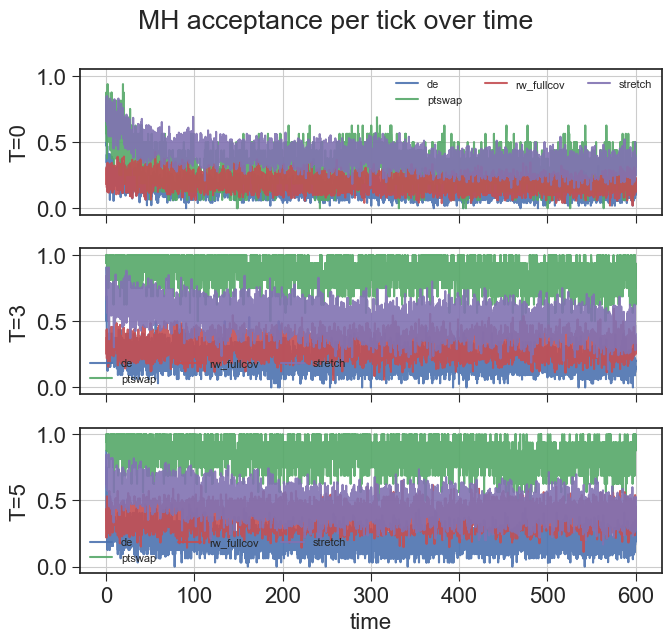

In [26]:
# (5) MH acceptance series per tick
acc_ts = mh_acceptance_timeseries(events, C=results.C)
for c in results.chain_inds:
    c = int(c)
    cm = acc_ts.get(c, {})
    if not cm: continue
    print(f"T{c} acceptance series:")
    for move, (times, rates) in cm.items():
        print(f"  {move}: {len(times)} ticks, mean acc={np.nanmean(rates):.2f}")


def plot_mh_acceptance_over_time(events: BD_MH.EventLog, trace: RunTrace):
    acc_ts = mh_acceptance_timeseries(events, C=trace.C)  # dict c -> move -> (times, rates)
    rows = len(trace.chain_inds)
    fig, axes = plt.subplots(rows, 1, figsize=(7, 2.2*rows), sharex=True)
    if rows == 1: axes = [axes]
    for r, c in enumerate(trace.chain_inds):
        c = int(c)
        ax = axes[r]
        series = acc_ts.get(c, {})
        if not series:
            ax.text(0.5, 0.5, f"No MH ticks for T={c}", ha="center")
        else:
            for move, (t, rate) in sorted(series.items()):
                ax.plot(t, rate, label=move, alpha=0.9)
            ax.set_ylim(-0.05, 1.05)
            ax.set_ylabel(f"T={c}")
            ax.legend(loc="best", ncols=3, fontsize=8)
    axes[-1].set_xlabel("time")
    fig.suptitle("MH acceptance per tick over time")
    fig.tight_layout()
    return fig, axes

plot_mh_acceptance_over_time(events, results)

(<Figure size 700x250 with 1 Axes>,
 <Axes: title={'center': 'k(t) mean at T=0'}, xlabel='time', ylabel='mean k over walkers'>)

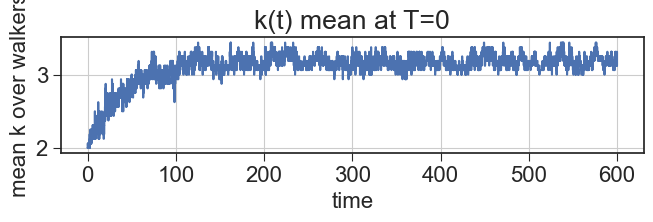

In [28]:
def plot_k_process(trace: RunTrace, temp_index: int = 0):
    # Build timeline of (t_abs, k_mean_over_walkers) using the same “final submove” for MH ticks
    entries: List[Tuple[float, float]] = []

    # BD states
    for ev in trace.bd_events:
        m = ev.m_sel[temp_index]     # (W,Kmax)
        k_w = m.sum(axis=1).astype(int)
        entries.append((ev.t_abs, float(k_w.mean())))

    # MH final states
    for tick in trace.mh_ticks:
        snap = _last_tick_state_snapshot(tick)
        if snap is None: 
            continue
        _, m_sel = snap
        m = m_sel[temp_index]
        k_w = m.sum(axis=1).astype(int)
        entries.append((tick.t_abs, float(k_w.mean())))

    if not entries:
        print("No states to plot.")
        return
    entries.sort()
    t = np.array([e[0] for e in entries])
    km = np.array([e[1] for e in entries])

    fig, ax = plt.subplots(figsize=(7, 2.5))
    ax.step(t, km, where="post")
    ax.set_xlabel("time")
    ax.set_ylabel("mean k over walkers")
    ax.set_title(f"k(t) mean at T={int(trace.chain_inds[temp_index])}")
    fig.tight_layout()
    return fig, ax

plot_k_process(results, temp_index=0)

In [24]:
MOVE_NAMES = {v:k for k,v in MOVE_IDS.items()}

def first_bad_submove_per_tick(trace: RunTrace, k: int, temp_index: int, ll_thresh: float):
    """
    For each tick+walker at selected temperature, find the FIRST submove in that tick
    where masked ll <= ll_thresh while currently in model size k.
    """
    csel = int(temp_index)
    out = []
    for t_idx, tick in enumerate(trace.mh_ticks):
        if not tick.submoves:
            continue
        W = trace.W
        first_hit = [False]*W
        prev_ll   = [None]*W
        for s_idx, snap in enumerate(tick.submoves):
            phi_c  = snap.phi_sel[csel]       # (W,Kmax,d)
            m_c    = snap.m_sel[csel]         # (W,Kmax)
            ll_c   = snap.ll_sel[csel]        # (W,)
            acc_c  = snap.accepted[csel]      # (W,)

            k_W = m_c.sum(axis=1).astype(int) # (W,)
            for w in range(W):
                if first_hit[w]:
                    continue
                if k_W[w] != k:
                    prev_ll[w] = float(ll_c[w]); continue
                cur_ll = float(ll_c[w])
                if cur_ll <= ll_thresh:
                    out.append(dict(
                        tick=t_idx, sub=s_idx, w=int(w), k=int(k),
                        t_abs=tick.t_abs, dt=tick.dt,
                        move=MOVE_NAMES[snap.move_id], slot=int(snap.slot_j),
                        accepted=bool(acc_c[w]),
                        prev_ll=None if prev_ll[w] is None else float(prev_ll[w]),
                        cur_ll=cur_ll
                    ))
                    first_hit[w] = True
                prev_ll[w] = cur_ll
    return out

def summarize_first_bad(trace: RunTrace, k: int, temp_index: int, ll_thresh: float):
    recs = first_bad_submove_per_tick(trace, k, temp_index, ll_thresh)
    from collections import Counter
    by_move = Counter((r["move"], r["accepted"]) for r in recs)
    print(f"[First-bad summary @ Tidx={temp_index}, k={k}, ll<= {ll_thresh:g}] events={len(recs)}")
    for key, cnt in by_move.items():
        print(f"  {key}: {cnt}")
    return recs

rec4 = summarize_first_bad(results, k=4, temp_index=temp_idx, ll_thresh=-250.944)
rec3 = summarize_first_bad(results, k=3, temp_index=temp_idx, ll_thresh=-250.944)

[First-bad summary @ Tidx=0, k=4, ll<= -250.944] events=0
[First-bad summary @ Tidx=0, k=3, ll<= -250.944] events=0


In [25]:
PTSWAP_ID = MOVE_IDS["ptswap"]

def _sel_index_map(trace: RunTrace):
    # full chain index -> index inside stored `*_sel` arrays
    return {int(c_full): i_sel for i_sel, c_full in enumerate(trace.chain_inds)}

def _neighbors(c_full: int):
    return (c_full-1, c_full+1)

def gather_last_snapshots(trace: RunTrace):
    """Return list of (snap_pre, snap_pt) for each MH tick that has at least 2 submoves.
       snap_pt is the last (ptswap), snap_pre is the last non-ptswap before it.
    """
    out = []
    for tick in trace.mh_ticks:
        if len(tick.submoves) < 2:
            continue
        snap_pt = tick.submoves[-1]
        if snap_pt.move_id != PTSWAP_ID:
            # your sweep appends ptswap as the last submove; if not, skip
            continue
        # previous submove (just before swap)
        snap_pre = tick.submoves[-2]
        out.append((snap_pre, snap_pt, tick))
    return out

def analyze_ptswap_outliers(trace: RunTrace, temp_index: int, k: int,
                            outlier_rule: str = "mad", mad_mult: float = 5.0,
                            fixed_drop: float | None = None, show_plot: bool = True):
    """
    For the selected temperature, collect LL AFTER the PT swap at each tick.
    Mark outliers and report what fraction coincide with accepted PT swaps.
    """
    c_full = int(trace.chain_inds[temp_index])
    snaps = gather_last_snapshots(trace)
    if not snaps:
        print("No (pre, ptswap) pairs found in trace.")
        return

    # Collect (ll_after, accepted_pt, k_after, tick_idx, walker)
    ll_after, acc_after, k_after_list, tids, ws = [], [], [], [], []
    for t_idx, (snap_pre, snap_pt, tick) in enumerate(snaps):
        ll_c  = snap_pt.ll_sel[temp_index]        # (W,)
        m_c   = snap_pt.m_sel[temp_index]         # (W,Kmax)
        k_w   = m_c.sum(axis=1).astype(int)       # (W,)
        acc_c = snap_pt.accepted[c_full]          # (W,) accepted PT at this (c_full, w)
        W = ll_c.shape[0]
        for w in range(W):
            if k_w[w] != k:
                continue
            ll_after.append(float(ll_c[w]))
            acc_after.append(bool(acc_c[w]))
            k_after_list.append(int(k_w[w]))
            tids.append(t_idx)
            ws.append(w)

    ll_after = np.asarray(ll_after)
    acc_after = np.asarray(acc_after, bool)
    tids = np.asarray(tids); ws = np.asarray(ws)

    if ll_after.size == 0:
        print(f"No k={k} samples found at temp index {temp_index} in ptswap snapshots.")
        return

    # Robust outlier rule
    if outlier_rule == "mad":
        med = np.median(ll_after)
        mad = np.median(np.abs(ll_after - med)) + 1e-12
        thr = med - mad_mult * 1.4826 * mad
    else:
        assert fixed_drop is not None, "fixed_drop must be provided for outlier_rule!='mad'"
        thr = np.median(ll_after) - float(fixed_drop)

    is_out = ll_after < thr

    n_all = ll_after.size
    n_out = int(is_out.sum())
    n_out_acc = int((is_out & acc_after).sum())
    n_out_rej = int((is_out & (~acc_after)).sum())

    print(f"[PT outlier check @ temp {c_full}, k={k}]")
    print(f"  total ptswap samples considered: {n_all}")
    print(f"  outliers (ll < {thr:.3f}): {n_out}  "
          f"(accepted PT: {n_out_acc}, rejected PT: {n_out_rej})")
    if n_out > 0:
        frac = n_out_acc / n_out
        print(f"  fraction of outliers with *accepted* PT swap: {frac:.3f}")

    if show_plot:
        plt.figure(figsize=(9,4))
        x = np.arange(n_all)
        plt.axhline(thr, ls="--", lw=1)
        plt.scatter(x[~acc_after], ll_after[~acc_after], s=6, alpha=0.4, label="PT not accepted")
        plt.scatter(x[acc_after],  ll_after[acc_after],  s=8, alpha=0.7, label="PT accepted")
        if is_out.any():
            plt.scatter(x[is_out],  ll_after[is_out],    s=16, alpha=0.9, facecolors='none', edgecolors='r', label="Outliers")
        plt.title(f"LL after PT swap (temp={c_full}, k={k})")
        plt.xlabel("sample index (over ticks with k)")
        plt.ylabel("masked log-likelihood")
        plt.legend()
        plt.tight_layout()
        plt.show()

def verify_ptswap_mirroring(trace: RunTrace, temp_index: int, tol: float = 1e-6, max_report: int = 10):
    """
    For the selected temperature, whenever a PT swap is *accepted* for a walker,
    check that the post-swap (φ, m, logπ, ll) equal the *partner* chain's pre-swap values.
    We look at the previous submove snapshot (snap_pre) vs the ptswap snapshot (snap_pt).
    """
    sel_map = _sel_index_map(trace)
    c_full = int(trace.chain_inds[temp_index])

    snaps = gather_last_snapshots(trace)
    if not snaps:
        print("No (pre, ptswap) pairs found in trace.")
        return

    # We can only verify if the partner chain is also in the saved selection.
    checked, mism = 0, 0
    examples = []

    for t_idx, (snap_pre, snap_pt, tick) in enumerate(snaps):
        acc_c_full = snap_pt.accepted[c_full]      # (W,)
        if not acc_c_full.any():
            continue

        # figure out partner (neighbor that also accepted)
        for w in np.where(acc_c_full)[0]:
            partner_full = None
            i_low, i_high = _neighbors(c_full)
            # prefer a neighbor that also accepted for the same walker
            if 0 <= i_low < trace.C and snap_pt.accepted[i_low, w]:
                partner_full = i_low
            elif 0 <= i_high < trace.C and snap_pt.accepted[i_high, w]:
                partner_full = i_high
            else:
                # couldn't identify partner (not in accept mask pair?), skip
                continue

            # Both chains must be in selection to read *_sel arrays
            if partner_full not in sel_map or c_full not in sel_map:
                continue

            ci = sel_map[c_full]
            cj = sel_map[partner_full]

            # PRE values come from the snapshot just before swap
            ll_pre_partner   = snap_pre.ll_sel[cj, w]
            phi_pre_partner  = snap_pre.phi_sel[cj, w]
            m_pre_partner    = snap_pre.m_sel[cj, w]
            logpi_pre_partner= snap_pre.logpi_sel[cj, w]

            # POST values at c_full after swap
            ll_post   = snap_pt.ll_sel[ci, w]
            phi_post  = snap_pt.phi_sel[ci, w]
            m_post    = snap_pt.m_sel[ci, w]
            logpi_post= snap_pt.logpi_sel[ci, w]

            checked += 1

            ok_ll    = np.allclose(ll_post,    ll_pre_partner,    atol=tol, rtol=0)
            ok_phi   = np.allclose(phi_post,   phi_pre_partner,   atol=tol, rtol=0)
            ok_m     = np.array_equal(m_post,  m_pre_partner)
            ok_logpi = np.allclose(logpi_post, logpi_pre_partner, atol=tol, rtol=0)

            if not (ok_ll and ok_phi and ok_m and ok_logpi):
                mism += 1
                if len(examples) < max_report:
                    examples.append({
                        "tick": t_idx, "walker": int(w),
                        "ok_ll": ok_ll, "ok_phi": ok_phi, "ok_m": ok_m, "ok_logpi": ok_logpi,
                        "d_ll": float(ll_post - ll_pre_partner)
                    })

    print(f"[PT mirror verification @ temp={c_full}] checked {checked} accepted swaps; mismatches: {mism}")
    for ex in examples:
        print("  mismatch example:", ex)

[PT outlier check @ temp 0, k=4]
  total ptswap samples considered: 9848
  outliers (ll < -246.703): 0  (accepted PT: 0, rejected PT: 0)


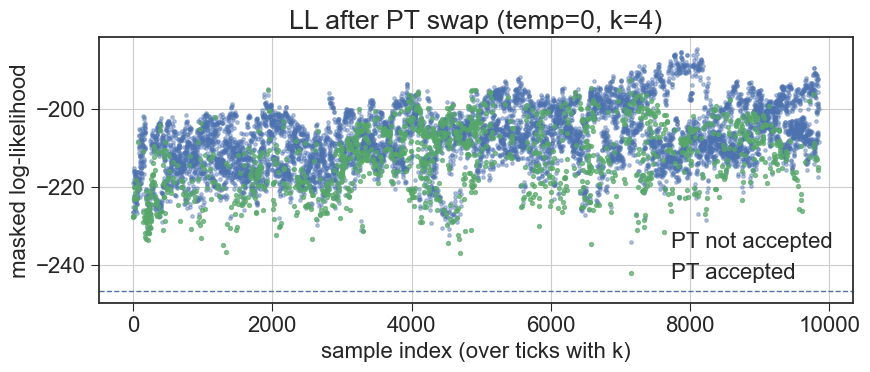

[PT mirror verification @ temp=0] checked 0 accepted swaps; mismatches: 0


In [26]:
temp_idx = 0    # whichever saved temperature you want to inspect
k = 4           # model size you care about

# 1) Are outliers tied to accepted PT swaps?
analyze_ptswap_outliers(results, temp_index=temp_idx, k=k,
                        outlier_rule="mad", mad_mult=5.0, show_plot=True)

# 2) Does the post-swap state at this temperature equal the partner’s pre-swap state?
verify_ptswap_mirroring(results, temp_index=temp_idx, tol=1e-6)

In [27]:
MOVE_NAMES = {v:k for k,v in MOVE_IDS.items()}

def find_outliers(trace: RunTrace, k: int, temp_index: int, ll_thresh: float):
    """
    Walk the saved MH ticks at a chosen temperature and model size k,
    return a list of outlier records with the move that produced them.
    """
    csel = int(temp_index)
    Csel, W, Kmax, d = len(trace.chain_inds), trace.W, trace.Kmax, trace.d

    outliers = []  # list of dicts
    for t_idx, tick in enumerate(trace.mh_ticks):
        t0 = tick.t_abs - tick.dt
        t1 = tick.t_abs

        # march through submoves in order; remember the *last* ll for each walker
        last_ll = np.full(W, np.nan)
        last_src = [None]*W  # (move_type, slot_j, accepted)

        for s_idx, snap in enumerate(tick.submoves):
            phi_c  = snap.phi_sel[csel]     # (W,Kmax,d)
            m_c    = snap.m_sel[csel]       # (W,Kmax)
            ll_c   = snap.ll_sel[csel]      # (W,)
            acc_c  = snap.accepted[csel]    # (W,)

            # Which walkers are currently in model k?
            k_W = m_c.sum(axis=1).astype(int)  # (W,)
            mask_k = (k_W == k)

            # For all walkers in model k, check for outliers
            for w in np.where(mask_k)[0]:
                llw = float(ll_c[w])
                if llw <= ll_thresh:
                    outliers.append(dict(
                        tick=t_idx, sub=s_idx, t_abs=tick.t_abs,
                        w=int(w), k=int(k), ll=llw,
                        move=MOVE_NAMES[snap.move_id], slot=int(snap.slot_j),
                        accepted=bool(acc_c[w]),
                        last_move=last_src[w],
                        last_ll=float(last_ll[w]) if not np.isnan(last_ll[w]) else None,
                    ))

            # update "last" info after processing
            for w in range(W):
                last_ll[w] = float(ll_c[w])
                last_src[w] = (MOVE_NAMES[snap.move_id], int(snap.slot_j), bool(acc_c[w]))

    return outliers

def had_recent_bd(trace: RunTrace, temp_index: int, w: int, t0: float, t1: float) -> bool:
    c = int(trace.chain_inds[temp_index])  # real temperature index
    for ev in trace.bd_events:
        if ev.c == c and ev.w == w and (t0 <= ev.t_abs <= t1):
            return True
    return False

def summarize_outliers(trace: RunTrace, k: int, temp_index: int, ll_thresh: float):
    outs = find_outliers(trace, k=k, temp_index=temp_index, ll_thresh=ll_thresh)

    # attach recent-BD flag
    for rec in outs:
        tick = trace.mh_ticks[rec["tick"]]
        rec["recent_bd"] = had_recent_bd(trace, temp_index, rec["w"], tick.t_abs - tick.dt, tick.t_abs)

    # counts by move
    from collections import Counter
    by_move = Counter((r["move"], r["accepted"]) for r in outs)
    by_recent_bd = sum(1 for r in outs if r["recent_bd"])

    print(f"[Outlier summary @ temp {temp_index}, k={k}, ll<= {ll_thresh:g}]")
    print(f"  total outliers: {len(outs)}")
    print(f"  with recent BD in same tick: {by_recent_bd}")
    print("  by move (move_type, accepted) -> count")
    for k_, v in by_move.items():
        print(f"    {k_}: {v}")

    return outs



In [28]:
outs4 = summarize_outliers(results, k=4, temp_index=temp_idx, ll_thresh=-250.944)
outs3 = summarize_outliers(results, k=3, temp_index=temp_idx, ll_thresh=-250.944)

[Outlier summary @ temp 0, k=4, ll<= -250.944]
  total outliers: 2248
  with recent BD in same tick: 136
  by move (move_type, accepted) -> count
    ('stretch', True): 152
    ('rw_fullcov', True): 248
    ('de', False): 512
    ('rw_fullcov', False): 476
    ('de', True): 210
    ('stretch', False): 571
    ('ptswap', True): 12
    ('ptswap', False): 67
[Outlier summary @ temp 0, k=3, ll<= -250.944]
  total outliers: 2298
  with recent BD in same tick: 49
  by move (move_type, accepted) -> count
    ('stretch', False): 606
    ('rw_fullcov', False): 555
    ('de', False): 583
    ('de', True): 135
    ('stretch', True): 114
    ('rw_fullcov', True): 163
    ('ptswap', True): 32
    ('ptswap', False): 110


In [32]:
import scipy.special as sc

def _log_uniform_masks_given_k(Kmax: int, k: np.ndarray) -> np.ndarray:
    # log p(m | k) = -log binom(Kmax, k)
    k = k.astype(np.int32)
    return - (sc.gammaln(Kmax + 1.) - sc.gammaln(k + 1.) - sc.gammaln(Kmax - k + 1.))

def _log_symmetrization(k: np.ndarray) -> np.ndarray:
    # log (1/k!) = -log(k!)
    return -sc.gammaln(k + 1.0)

In [35]:
for ii in range(1, 5):
    print ('uniform over masks, k=', ii, ' log prob:', _log_uniform_masks_given_k(4, np.array([ii]))[0])
    print ('symmetrization term, k=', ii, ' log prob:', _log_symmetrization(np.array([ii]))[0])
    print ('total:', _log_uniform_masks_given_k(4, np.array([ii]))[0] + _log_symmetrization(np.array([ii]))[0]  )

uniform over masks, k= 1  log prob: -1.3862943611198908
symmetrization term, k= 1  log prob: -0.0
total: -1.3862943611198908
uniform over masks, k= 2  log prob: -1.791759469228055
symmetrization term, k= 2  log prob: -0.6931471805599453
total: -2.4849066497880004
uniform over masks, k= 3  log prob: -1.3862943611198908
symmetrization term, k= 3  log prob: -1.791759469228055
total: -3.1780538303479458
uniform over masks, k= 4  log prob: -0.0
symmetrization term, k= 4  log prob: -3.1780538303479458
total: -3.1780538303479458


In [10]:
print ('shapes', C, W, Kmax, Npar_src)

# print(pt_out)
thetas = pt_out.thetas
log_probs = pt_out.log_probs
print (thetas.shape, log_probs.shape)

# print (ps_out)
print (ps_out.m.shape)
# print (ps_out.m[0, :, :])
print ('here', ps_out.m[0,:,:].sum(axis=1))   # k
print (ps_out.logpi.shape)
print (ps_out.logpi[0,  :])
print (ps_out.phi.shape)
print (ps_out.phi[0, -1, :, :])

shapes 6 16 4 8
(6, 16, 32) (6, 16)
(6, 16, 4)
here [3 3 3 4 3 3 2 4 3 3 3 3 3 3 3 3]
(6, 16)
[-1.32206971e+04 -1.34022936e+02 -2.74474603e+02 -1.10021060e+06
 -2.09743345e+02 -2.17009941e+02 -2.41669458e+02 -1.90282181e+05
 -2.09842461e+02 -2.13512472e+02 -2.10476455e+02 -2.10407255e+02
 -1.45552154e+06 -1.31793698e+02 -1.34300632e+02 -2.08196692e+02]
(6, 16, 4, 8)
[[0.32902433 0.48971292 0.49996613 0.61328111 0.75777918 0.55314375
  0.63001596 0.0963585 ]
 [0.37928869 0.85365692 0.51275093 0.45530456 0.73053031 0.35094105
  0.03498939 0.27329539]
 [0.34366589 0.73077031 0.50488585 0.04990812 0.47691247 0.52526995
  0.97774005 0.65981764]
 [0.65883209 0.47823044 0.97623088 0.58047855 0.70817109 0.79423278
  0.41409718 0.93443494]]


In [37]:
print ('BD events', len(events.bd_events))
print ('MH events', len(events.mh_events))
# for ii, db in enumerate(events.bd_events):
#     print ('here', db.t_abs)

# for ii, mh in enumerate(events.mh_events):
mh = events.mh_events[0]
print (mh)
mh = events.mh_events[1078]
print (mh)

    # print ('here mh', mh.dt)

print (len(results.bd_events))
print (len(results.mh_ticks))
print (len(results.mh_ticks[0].submoves))
print (results.mh_ticks[0].submoves[0].move_id)
print (results.mh_ticks[0].submoves[0].slot_j)
print (results.mh_ticks[0].submoves[0].logpi_sel)#ll_sel)


BD events 176
MH events 24510
MHEvent(t_abs=0.04740535832882452, dt=0.0015040281972634323, c=0, w=0, slot=0, move_type='stretch', accepted=True)
MHEvent(t_abs=0.06635382770670116, dt=0.018948469377876642, c=0, w=14, slot=1, move_type='rw_fullcov', accepted=False)
176
31
13
0
0
[[    0.             0.             0.             0.
  -3286.32807406     0.             0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.        ]
 [    0.             0.             0.             0.
    -55.38346358     0.             0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.        ]
 [    0.             0.             0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.        ]]


In [39]:
from collections import defaultdict, Counter
from typing import Dict, List, Tuple, Optional

MOVE_IDS = {"stretch": 0, "rw_fullcov": 1, "rw_eigenline": 2,
            "rw_student_t": 3, "de": 4, "ptswap": 5}

# ---------- Small utilities ----------

def _sel_pos(trace: BD_MH.RunTrace, temp_index: int) -> int:
    """Map absolute temperature index 'temp_index' -> its position in trace.chain_inds."""
    where = np.where(trace.chain_inds == temp_index)[0]
    if where.size == 0:
        raise ValueError(f"temp_index {temp_index} was not recorded (chain_inds={trace.chain_inds.tolist()}).")
    return int(where[0])

def _iter_mh_snapshots_for_temp(trace: BD_MH.RunTrace, temp_index: int):
    """
    Yield (t_abs, move_id, slot_j, accepted_W, thetas_WD, ll_W, phi_WKmaxd, m_WKmax, logpi_W).
    Shapes are per-walker (W,...). State is AFTER the submove.
    """
    ci = _sel_pos(trace, temp_index)
    for tick in trace.mh_ticks:
        for sub in tick.submoves:
            # Slice the selected temperature across all walkers
            accepted_W   = sub.accepted[temp_index] if sub.accepted.shape[0] == trace.C else sub.accepted[ci]
            thetas_WD    = sub.thetas_sel[ci]      # (W,D)
            ll_W         = sub.ll_sel[ci]          # (W,)
            phi_WKmaxd   = sub.phi_sel[ci]         # (W,Kmax,d)
            m_WKmax      = sub.m_sel[ci]           # (W,Kmax)
            logpi_W      = sub.logpi_sel[ci]       # (W,)
            yield (tick.t_abs, sub.move_id, sub.slot_j, accepted_W, thetas_WD, ll_W, phi_WKmaxd, m_WKmax, logpi_W)

def _iter_bd_snapshots_for_temp(trace: BD_MH.RunTrace, temp_index: int):
    """
    Yield (t_abs, kind, slot, thetas=None, ll_W=None, phi_WKmaxd, m_WKmax, logpi_W).
    BD events only carry PS snapshots (no theta/ll in your structure).
    """
    ci = _sel_pos(trace, temp_index)
    for ev in trace.bd_events:
        if ev.phi_sel is None:  # user may disable PS snapshots on BD
            continue
        phi_WKmaxd = ev.phi_sel[ci]        # (W,Kmax,d)
        m_WKmax    = ev.m_sel[ci]          # (W,Kmax)
        logpi_W    = ev.logpi_sel[ci]      # (W,)
        yield (ev.t_abs, ev.kind, ev.slot, phi_WKmaxd, m_WKmax, logpi_W)


In [72]:

def collect_phi_samples_by_k(
    trace: BD_MH.RunTrace,
    temp_index: int = 0,
    *,
    include_bd: bool = True,
    include_mh: bool = True,
    thin: int = 1,
) -> dict[int, np.ndarray]:
    """
    Return dict k -> array of shape (N_k, k, d)
    """
    out: dict[int, list[np.ndarray]] = defaultdict(list)
    W, Kmax, d = trace.W, trace.Kmax, trace.d

    # BD snapshots
    if include_bd:
        for ev in trace.bd_events[::thin]:
            phi = ev.phi_sel[temp_index]     # (W,Kmax,d)
            m   = ev.m_sel[temp_index]       # (W,Kmax)
            for w in range(W):
                act = m[w]                   # (Kmax,) bool
                k = int(act.sum())
                if k > 0:
                    out[k].append(phi[w, act, :])  # (k,d)

    # MH submove snapshots
    if include_mh:
        for tick in trace.mh_ticks[::thin]:
            for snap in tick.submoves:
                phi = snap.phi_sel[temp_index]   # (W,Kmax,d)
                m   = snap.m_sel[temp_index]     # (W,Kmax)
                for w in range(W):
                    act = m[w]
                    k = int(act.sum())
                    if k > 0:
                        out[k].append(phi[w, act, :])

    # stack
    return {k: np.stack(v, axis=0) for k, v in out.items()}

In [74]:
phis_k = collect_phi_samples_by_k(results, temp_index=0)  # cold chain

for k, arr in sorted(phis_k.items()):
    print(f"k={k}: samples shape {arr.shape}")  # -> (N_k, k, d)

# print (len(phis_k))

# print("k values with samples:", sorted(phis_k.keys()))
# print("e.g. first φ sample for k=2 has shape", phis_k[2][0].shape)  # (1,2,d)
# print (len(phis_k[2]))
# print (len(phis_k[3]))
# print("e.g. first φ sample for k=3 has shape", phis_k[3][0].shape) 
# print (len(phis_k[4]))
# print("e.g. first φ sample for k=4 has shape", phis_k[4][1].shape)

# for k, arr in phis_k.items():
#     print(f"k={k}: shape {arr.shape}")

k=2: samples shape (3730, 2, 8)
k=3: samples shape (5275, 3, 8)
k=4: samples shape (259, 4, 8)


In [77]:
temp_i = 0

def posterior_over_k(
    trace: BD_MH.RunTrace,
    temp_index: int = 0,
    *,
    include_bd: bool = True,
    include_mh: bool = True,
    thin: int = 1,
) -> tuple[np.ndarray, dict[int, np.ndarray]]:
    """
    Returns:
      post_k: (Kmax+1,) empirical p(k|y) at temp_index
      by_k  : dict k -> (N_k, k, d) φ-samples (same selection options)
    """
    Kmax = trace.Kmax
    counts = np.zeros(Kmax + 1, dtype=np.int64)

    if include_bd:
        for ev in trace.bd_events[::thin]:
            m = ev.m_sel[temp_index]  # (W,Kmax)
            counts += np.bincount(m.sum(axis=1).astype(int), minlength=Kmax + 1)

    if include_mh:
        for tick in trace.mh_ticks[::thin]:
            for snap in tick.submoves:
                m = snap.m_sel[temp_index]
                counts += np.bincount(m.sum(axis=1).astype(int), minlength=Kmax + 1)

    total = counts.sum()
    post_k = counts / total if total > 0 else counts
    by_k = collect_phi_samples_by_k(trace, temp_index=temp_index,
                                    include_bd=include_bd, include_mh=include_mh, thin=thin)
    return post_k, by_k

# Example
post_k, by_k = posterior_over_k(results, temp_index=temp_i, include_bd=False, include_mh=True)
print (post_k.shape)
print("Posterior p(k|y) at temp", results.chain_inds[temp_i], ":", post_k)

(5,)
Posterior p(k|y) at temp 0 : [0.         0.         0.40167494 0.56947891 0.02884615]


In [79]:
def bayes_factors_from_postk(
    post_k: np.ndarray,
    prior_k: np.ndarray | None = None,
    ks: list[int] | None = None,
) -> dict[tuple[int,int], float]:
    """
    Return pairwise Bayes factors BF[(k1,k2)].
    If prior_k is None -> assume flat over observed support.
    """
    Kmax = len(post_k) - 1
    if ks is None:
        ks = [k for k in range(Kmax + 1) if post_k[k] > 0]
    ks = list(ks)

    if prior_k is None:
        prior_k = np.ones_like(post_k, dtype=float)
        prior_k = prior_k / prior_k.sum()
    else:
        prior_k = np.asarray(prior_k, float)
        prior_k = prior_k / prior_k.sum()

    BF = {}
    for i in range(len(ks)):
        for j in range(i + 1, len(ks)):
            k1, k2 = ks[i], ks[j]
            post_odds  = (post_k[k1] / post_k[k2]) if (post_k[k1] > 0 and post_k[k2] > 0) else np.nan
            prior_odds = (prior_k[k1] / prior_k[k2]) if (prior_k[k1] > 0 and prior_k[k2] > 0) else np.nan
            BF[(k1, k2)] = post_odds / prior_odds if (post_odds > 0 and prior_odds > 0) else np.nan
    return BF

# Example (flat prior over k):
BF = bayes_factors_from_postk(post_k)
for (k1,k2), v in sorted(BF.items()):
    print(f"BF({k1} vs {k2}) = {v:.3g}")

BF(2 vs 3) = 0.705
BF(2 vs 4) = 13.9
BF(3 vs 4) = 19.7


In [ ]:
def total_time_from_trace(trace: BD_MH.RunTrace) -> float:
    t_bd = trace.bd_events[-1].t_abs if trace.bd_events else 0.0
    t_mh = trace.mh_ticks[-1].t_abs  if trace.mh_ticks  else 0.0
    return max(t_bd, t_mh)

def bd_diagnostics(trace: BD_MH.RunTrace) -> dict[int, dict[str, float]]:
    """
    Returns dict c -> {'births':..., 'deaths':..., 'net':..., 'birth_rate':..., 'death_rate':...}
    where c is the absolute temperature index in [0..C-1].
    Only BD events that happened at the saved temps (trace.chain_inds) will be summarized if you filter below.
    """
    C = trace.C
    births = np.zeros(C, dtype=int)
    deaths = np.zeros(C, dtype=int)
    for ev in trace.bd_events:
        if ev.kind == 0: births[ev.c] += 1
        elif ev.kind == 1: deaths[ev.c] += 1
    T = total_time_from_trace(trace)
    out = {}
    for c in trace.chain_inds:  # only saved temps
        out[int(c)] = dict(
            births=int(births[c]),
            deaths=int(deaths[c]),
            net=int(births[c] - deaths[c]),
            birth_rate=(births[c] / T) if T > 0 else np.nan,
            death_rate=(deaths[c] / T) if T > 0 else np.nan,
        )
    return out

# Example
bd_diag = bd_diagnostics(results)
for c, d in sorted(bd_diag.items()):
    print(f"T{c}: births={d['births']} deaths={d['deaths']} "
          f"rates=({d['birth_rate']:.3g},{d['death_rate']:.3g})/unit time")
    

T0: births=39 deaths=14 rates=(19.5,7)/unit time
T3: births=17 deaths=5 rates=(8.5,2.5)/unit time
T5: births=7 deaths=8 rates=(3.5,4)/unit time


In [85]:
from collections import defaultdict

MOVE_SHORT = {
    "stretch": "SM",
    "rw_fullcov": "RW",
    "rw_eigenline": "RWeig",
    "rw_student_t": "RWt",
    "de": "DE",
    "ptswap": "PT",
}

def mh_acceptance_by_temp(events: BD_MH.EventLog, C: int) -> dict[int, dict[str, tuple[int,int,float]]]:
    """
    Return dict c -> dict short_move -> (accepted, attempted, rate)
    """
    acc = {c: defaultdict(lambda: [0,0]) for c in range(C)}  # [accepted, attempted]
    for ev in events.mh_events:
        key = MOVE_SHORT.get(ev.move_type, ev.move_type)
        a = acc[ev.c][key]
        a[1] += 1
        if ev.accepted: a[0] += 1

    out = {}
    for c in range(C):
        inner = {}
        for key, (ok, tot) in acc[c].items():
            inner[key] = (ok, tot, ok / tot if tot > 0 else np.nan)
        out[c] = inner
    return out

# Example: print only saved temps
acc_diag = mh_acceptance_by_temp(events, C=results.C)
for c in results.chain_inds:
    row = acc_diag[int(c)]
    pretty = ", ".join(f"{m}:{ok}/{tot}={rate:.2f}" for m,(ok,tot,rate) in row.items())
    print(f"T{c}: {pretty}")

T0: SM:792/1304=0.61, RW:129/1304=0.10, DE:560/1270=0.44, PT:168/496=0.34
T3: SM:651/1125=0.58, RW:192/1125=0.17, DE:489/1077=0.45, PT:444/496=0.90
T5: SM:672/1113=0.60, RW:315/1113=0.28, DE:589/1080=0.55, PT:283/496=0.57


In [ ]:
# example

# from dataclasses import dataclass

# # ---- Your state containers (as in your code) --------------------------------
# # PTState, PSState, EventLog, etc. assumed imported from your module

# # ---- Problem setup -----------------------------------------------------------
# C = 3                     # number of temperatures
# W = 4                     # walkers per temperature
# Kmax = 4                  # max number of sources/slots
# d = 2                     # per-source parameter dimension
# D = Kmax * d              # concatenated θ dimension

# # Temperatures (betas = 1/T)
# temps = np.array([1.0, 2.0, 4.0])      # example ladder
# betas = 1.0 / temps                    # (C,)

# # Slot mapping: pack φ_j (d dims) into θ (D dims)
# slot_slices = tuple(slice(j*d, (j+1)*d) for j in range(Kmax))  # (slice(0,2), slice(2,4), ...)

# # Synthetic data for the likelihood (same y for all (c,w) for simplicity)
# y = np.array([1.0, -1.0], dtype=np.float64)   # target/location
# Drest = d  # we’ll pass 'y' via rest

# # ---- Priors & pseudo-priors --------------------------------------------------
# tau = 2.0
# tau2 = tau**2
# tau_psi = 5.0
# tau2_psi = tau_psi**2

# def log_prior_phi_np(phi_j: np.ndarray) -> float:
#     # N(0, tau^2 I)
#     r2 = float(np.dot(phi_j, phi_j))
#     return -0.5 * (r2 / tau2 + d * np.log(2.0 * np.pi * tau2))

# def log_pseudo_phi_np(phi_j: np.ndarray) -> float:
#     # N(0, tau_psi^2 I) (used when slot is OFF)
#     r2 = float(np.dot(phi_j, phi_j))
#     return -0.5 * (r2 / tau2_psi + d * np.log(2.0 * np.pi * tau2_psi))

# # Uniform prior over k ∈ {2,3,4}; -inf otherwise
# def log_p_k_np(k_arr: np.ndarray) -> np.ndarray:
#     out = np.full_like(k_arr, -np.inf, dtype=np.float64)
#     mask = (k_arr == 2) | (k_arr == 3) | (k_arr == 4)
#     out = np.where(mask, -np.log(3.0), out)
#     return out

# # ---- Birth/Death “rate density” qb ------------------------------------------
# # Keep it simple: constant positive rate per (c,w), possibly depending on ctx
# def qb_density_np(phi_j_cw: np.ndarray,
#                   m_ctx_cw: np.ndarray,
#                   phi_all_cw: np.ndarray,
#                   rest_cw: np.ndarray | None) -> np.ndarray:
#     # shape: (C,W,d), (C,W,Kmax), (C,W,Kmax,d) -> return (C,W)
#     return np.ones(phi_j_cw.shape[:2], dtype=np.float64)

# # ---- Pseudo-prior sampler for replacing φ on death ---------------------------
# rng_np = np.random.default_rng(0)
# def sample_pseudo_phi() -> np.ndarray:
#     return rng_np.normal(0.0, tau_psi, size=(d,)).astype(np.float64)

# # ---- Masked likelihood (single config, JAX) ----------------------------------
# # Log-lik = sum over active slots of log N(y | φ_j, σ^2 I)
# sigma = 0.5
# sigma2 = sigma**2
# const_term = -0.5 * d * jnp.log(2.0 * jnp.pi * sigma2)

# def log_lik_masked_jax(phi_kwd: jnp.ndarray, m_k: jnp.ndarray, rest_d: jnp.ndarray | None) -> jnp.ndarray:
#     # phi_kwd: (Kmax, d), m_k: (Kmax,), rest_d: (d,) == y
#     y_here = rest_d if rest_d is not None else jnp.zeros((d,))
#     diffs = phi_kwd - y_here[None, :]                       # (Kmax,d)
#     ll_j = const_term - 0.5 * jnp.sum(diffs**2, axis=1) / sigma2  # (Kmax,)
#     return jnp.sum(jnp.where(m_k, ll_j, 0.0))

# # ---- Build initial states ----------------------------------------------------
# # Start with k=2 active everywhere (slots 0 and 1 ON)
# m0 = np.zeros((C, W, Kmax), dtype=bool)
# m0[:, :, :2] = True

# # Initial φ ~ pseudo-prior (or prior); here pseudo for all slots
# phi0 = rng_np.normal(0.0, tau_psi, size=(C, W, Kmax, d)).astype(np.float64)

# # θ packs φ_j into contiguous slices
# thetas0 = np.zeros((C, W, D), dtype=np.float64)
# for j in range(Kmax):
#     sl = slot_slices[j]
#     thetas0[:, :, sl] = phi0[:, :, j, :]

# # REST holds y (replicated for each (c,w))
# rest = np.broadcast_to(y, (C, W, d)).copy()

# # Compute initial masked log-likelihood per (c,w) via your helper
# from ptdamh.BD_MH_step_numpy import make_batched_loglik_masked  # adjust import to your path
# batched_ll_masked = make_batched_loglik_masked(log_lik_masked_jax)

# B = C * W
# ll0 = batched_ll_masked(
#     phi0.reshape(B, Kmax, d),
#     m0.reshape(B, Kmax),
#     rest.reshape(B, d),
# ).reshape(C, W)

# pt_init = PTState(thetas=thetas0, log_probs=ll0)   # log_probs = masked LL
# ps_init = PSState(phi=phi0, m=m0, rest=rest, logpi=np.zeros((C, W), dtype=np.float64))

# # ---- Runner knobs ------------------------------------------------------------
# T_end = 2.0            # total CTMC time
# rho_mh = 10.0          # MH global Poisson rate
# do_stretch = True
# do_rw_fullcov = False  # keep off to avoid needing Ls
# do_de = True

# # (Optional) resources for RW moves if you enable them
# Ls = None; U = None; S = None

# # ---- Call run_epoch_ct_numpy -------------------------------------------------
# from ptdamh.BD_MH_step_numpy import run_epoch_ct_numpy  # adjust import to your path

# pt_out, ps_out, events = run_epoch_ct_numpy(
#     seed=123,
#     pt_init=pt_init,
#     ps_init=ps_init,
#     T_end=T_end,
#     rho_mh=rho_mh,
#     betas=betas,
#     qb_density_np=qb_density_np,
#     qb_eval_variant="child",                 # evaluate qb in child context for births; parent for deaths (handled inside)
#     log_prior_phi_np=log_prior_phi_np,
#     log_pseudo_phi_np=log_pseudo_phi_np,
#     log_p_k_np=log_p_k_np,
#     log_lik_masked_jax=log_lik_masked_jax,  # JAX single-config (masked)
#     slot_slices=slot_slices,
#     # RW resources
#     Ls=Ls, U=U, S=S,
#     # MH knobs
#     do_stretch=do_stretch,
#     do_rw_fullcov=do_rw_fullcov,
#     do_rw_eigenline=False,
#     do_rw_student_t=False,
#     do_de=do_de,
#     stretch_a=1.3,
#     cross_rate=0.7,
#     gamma_de=2.38,
#     # pseudo-prior sampler
#     sample_pseudo_phi=sample_pseudo_phi,
# )

# # ---- Inspect results ---------------------------------------------------------
# print("Final θ shape:", pt_out.thetas.shape)
# print("Final masked LL shape:", pt_out.log_probs.shape)
# print("Active counts per (C,W):")
# print(ps_out.m.sum(axis=-1))   # (C,W)

# print(f"#BD events: {len(events.bd_events)}   #MH events: {len(events.mh_events)}")
# if events.bd_events:
#     ev = events.bd_events[0]
#     print("First BD event:", ev)

